<h1 style="color:yellow;">Concurrent Data - Deep Learning</h1>

# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import gc
import time
import sys
sys.path.append(os.path.abspath(".."))

from utils import print_evaluation_metrics, print_memory_usage, clean_database, \
    analyze_correlations, perform_voting_feature_selection, \
    log_metrics, plot_individual_metrics, explore_dataset
from preprocess import preprocessing

pd.set_option('display.max_columns', None)
preprocessing_output_dir = os.getcwd()
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attack Type                                           
Benign          0.392901  0.392743  0.393307  0.393759
HTTPFlood       0.115812  0.115800  0.115259  0.116460
ICMPFlood       0.000950  0.000945  0.001003  0.000938
SYNFlood        0.007995  0.007945  0.008389  0.008003
SYNScan         0.016485  0.016527  0.016515

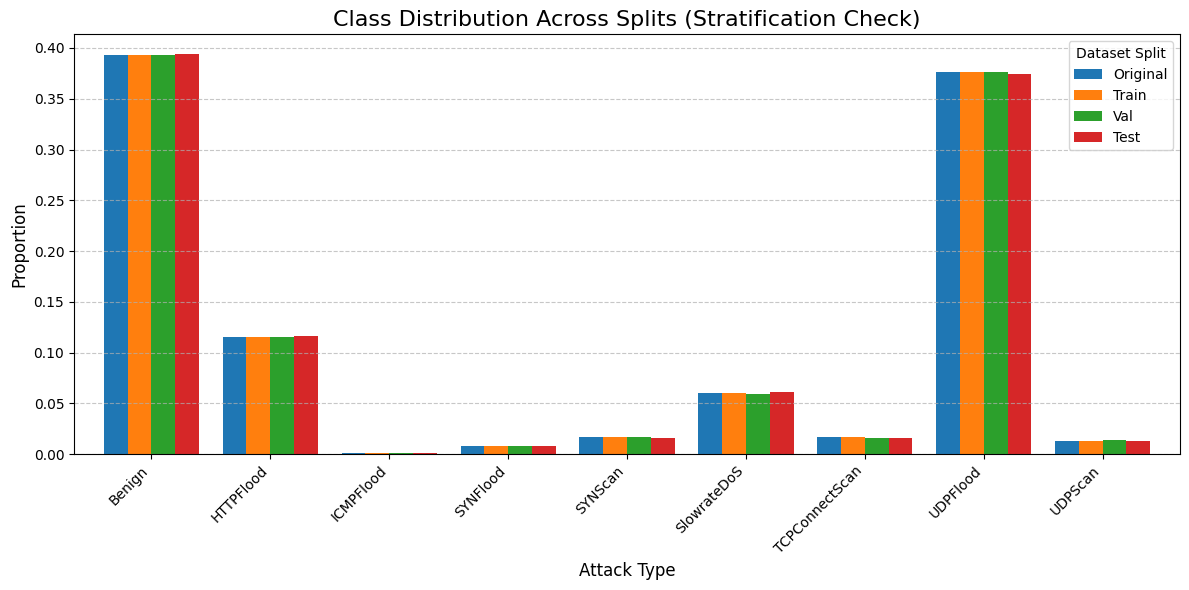

[Memory] Before GC: 1686.23 MB
[Memory] After GC: 1454.31 MB
[Preprocessing] Applying PowerTransformer (Yeo-Johnson) to fix skewness and standardize data...
[Visualization] Plotting top 3 skewed features before transformation: ['DstGap', 'SrcGap', 'DstRate']


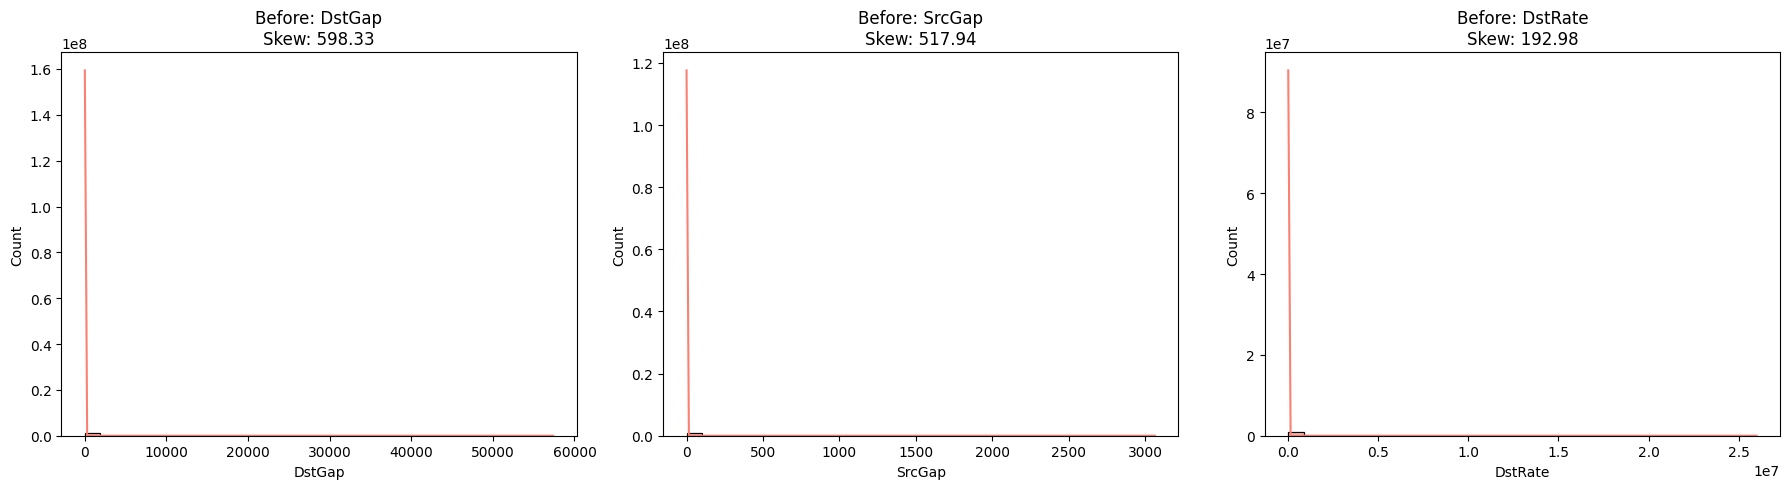

[Visualization] Plotting top 3 skewed features after transformation


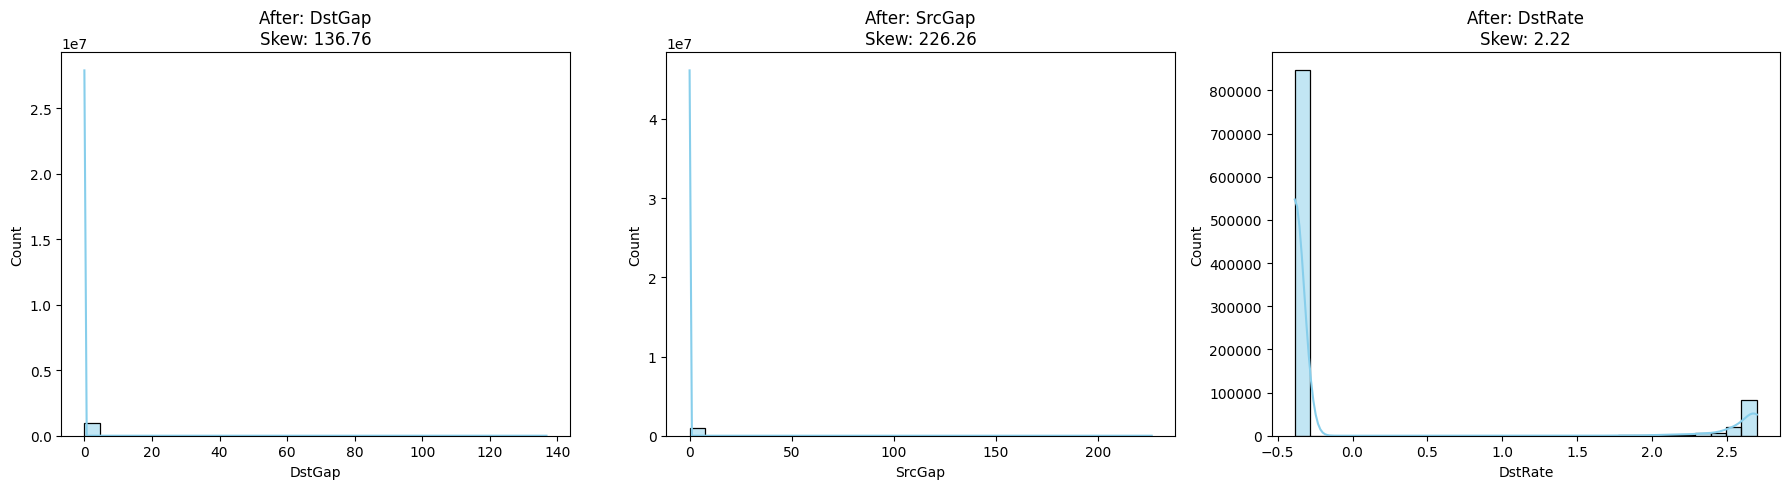

<class 'pandas.core.frame.DataFrame'>
Index: 972695 entries, 285273 to 583254
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972695 non-null  float32
 1   Mean        972695 non-null  float32
 2   Sum         972695 non-null  float32
 3   Min         972695 non-null  float32
 4   Max         972695 non-null  float32
 5   Proto       972695 non-null  float32
 6   sTos        972695 non-null  float32
 7   dTos        972695 non-null  float32
 8   sDSb        972695 non-null  float32
 9   dDSb        972695 non-null  float32
 10  sTtl        972695 non-null  float32
 11  dTtl        972695 non-null  float32
 12  Cause       972695 non-null  float32
 13  TotPkts     972695 non-null  float32
 14  SrcPkts     972695 non-null  float32
 15  DstPkts     972695 non-null  float32
 16  TotBytes    972695 non-null  float32
 17  SrcBytes    972695 non-null  float32
 18  DstBytes    972695 non-null  float32
 19  Of

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_output_dir, do_scale=False, fix_skewness=True)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()
print_memory_usage("Notebook - After clean_database")

# Feature Selection

## Correlations

### Analyze correlation between featrues

[Memory] Notebook - Before Correlation Analysis: 2325.59 MB


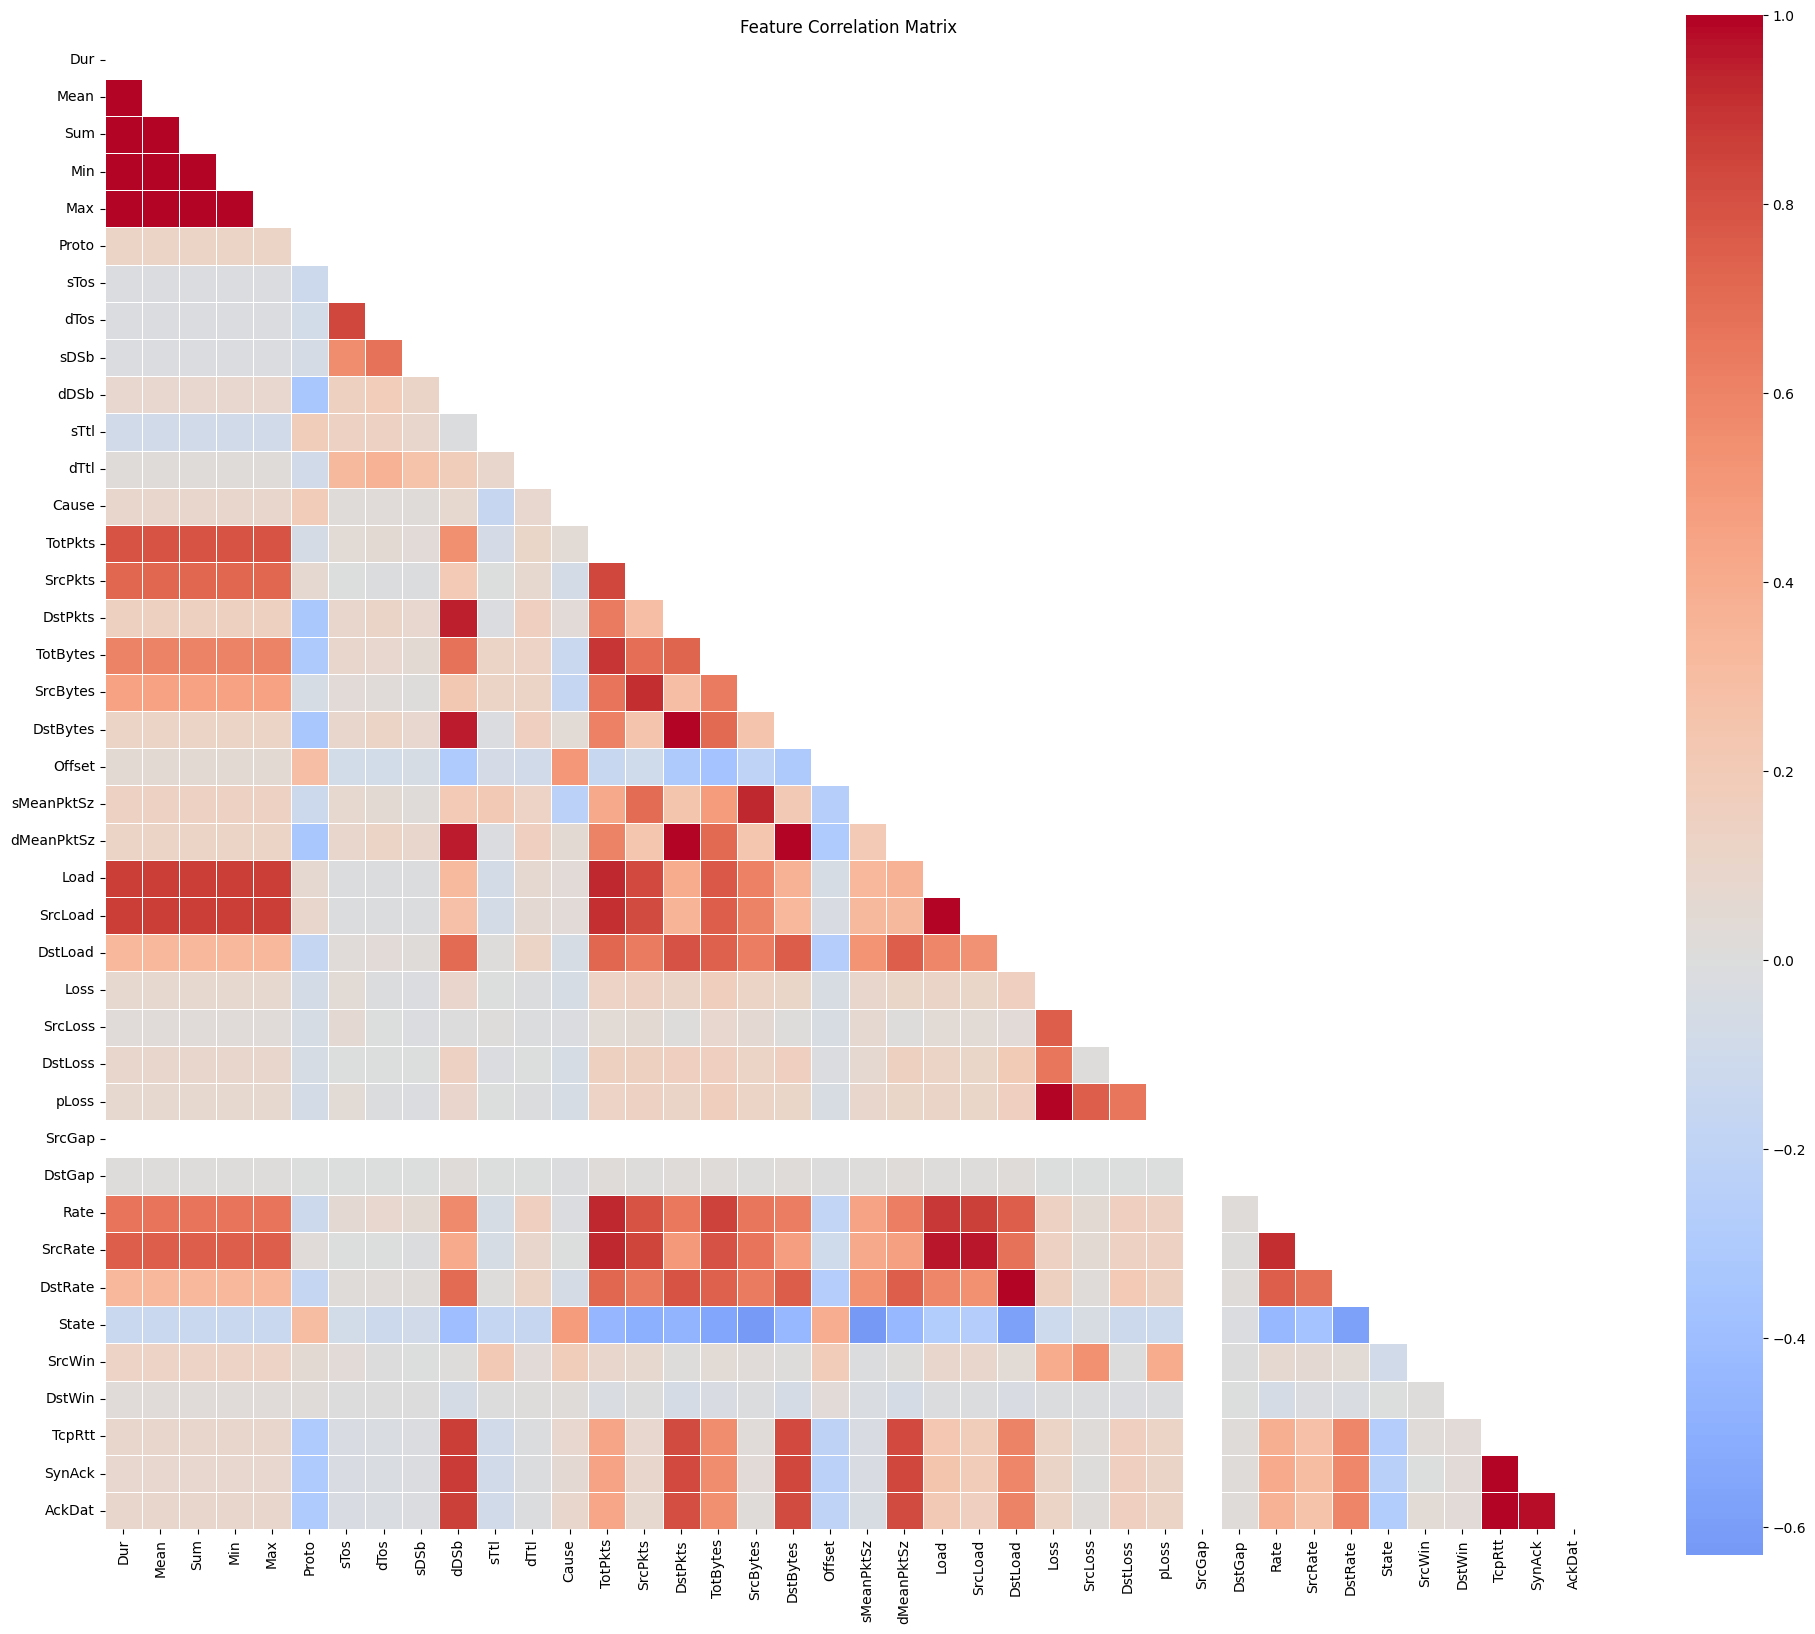


[Analysis] Features with correlation > 0.95:
  - Mean is correlated with ['Dur']
  - Sum is correlated with ['Dur', 'Mean']
  - Min is correlated with ['Dur', 'Mean', 'Sum']
  - Max is correlated with ['Dur', 'Mean', 'Sum', 'Min']
  - DstBytes is correlated with ['dDSb', 'DstPkts']
  - dMeanPktSz is correlated with ['dDSb', 'DstPkts', 'DstBytes']
  - SrcLoad is correlated with ['Load']
  - pLoss is correlated with ['Loss']
  - SrcRate is correlated with ['Load', 'SrcLoad']
  - DstRate is correlated with ['DstLoad']
  - SynAck is correlated with ['TcpRtt']
  - AckDat is correlated with ['TcpRtt', 'SynAck']
[Memory] Notebook - After Correlation Analysis: 2292.81 MB


In [ ]:
high_corr_features = analyze_correlations(X_train, threshold=0.95)

### Drop correlated featuers

In [ ]:
# Use inplace=True to avoid creating a copy of the dataframe in memory
X_train.drop(columns=high_corr_features, inplace=True)
X_val.drop(columns=high_corr_features, inplace=True)
X_test.drop(columns=high_corr_features, inplace=True)
print(f"Dropped {len(high_corr_features)} correlated features.")

gc.collect()
print_memory_usage("Notebook - After Dropping Correlated Features")

Dropped 12 correlated features.
[Memory] Notebook - After Dropping Correlated Features: 2292.81 MB


In [ ]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

# Arguments

In [ ]:
version = 'v1'
sampling_method = 'smote'
plot_distributions = True
model_results= []
lr_notes = """
- Preprocessing: Yeo-Johnson transform applied.
- Feature Selection: Voting method with top 3 selectors.
- Sampling: SMOTE used on the training set.
- Fixed the problem of the feature selection function not having a random state parameter for reproducibility."""
preprocessing_args_list = [X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_output_dir, version, sampling_method, plot_distributions]

## Compare the results of all methods

[Memory] Notebook - Before Feature Selection: 2292.81 MB

[Comparison] Downsampling training data to 50000 samples for feature selection...

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 20 features...
[Filter] Completed in 0.00 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Filter Method: anova ---

[Filter] Starting ANOVA Feature Selection to select top 20 features...
[Filter] Completed in 0.00 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'DstLoss', 'Rate', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Filter Method: chi2 ---


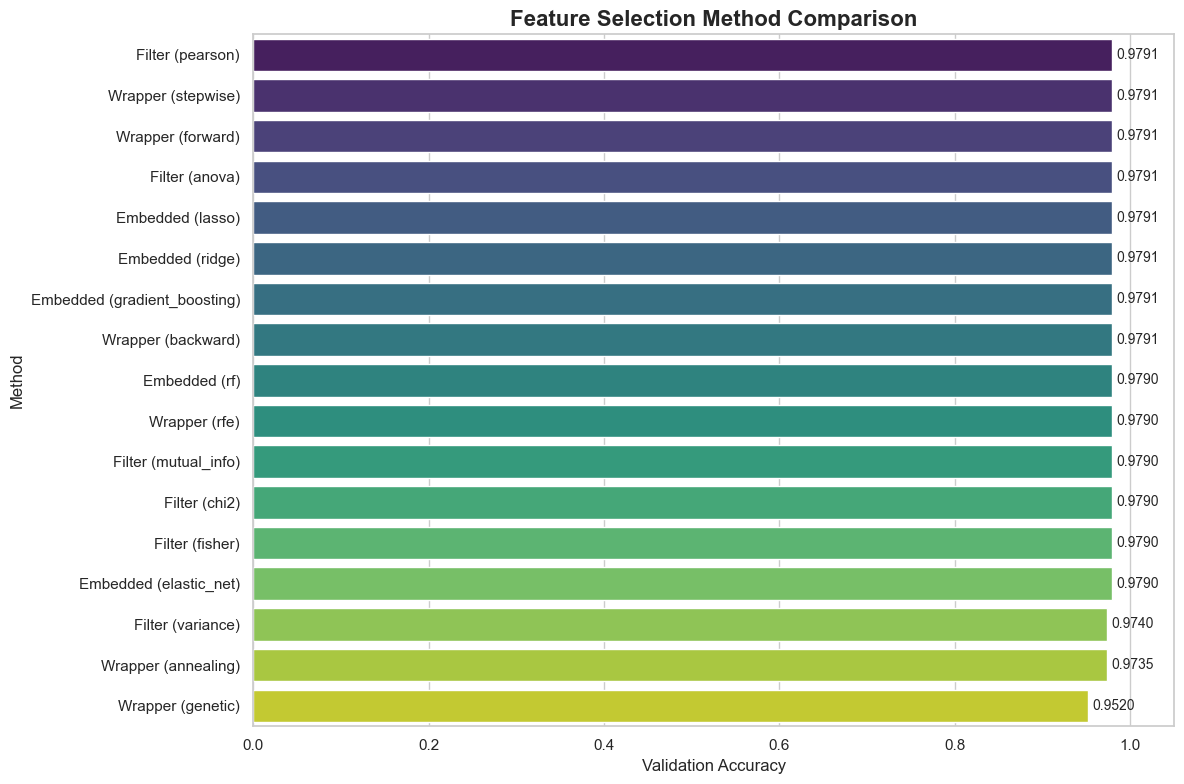


Starting Voting Feature Selection (Top 3 Methods)
Top 3 methods selected for voting:
  - Filter (pearson) (Accuracy: 0.9791)
  - Wrapper (forward) (Accuracy: 0.9791)
  - Wrapper (stepwise) (Accuracy: 0.9791)

[Voting] Features selected by majority (2+ votes): ['Dur', 'Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'Cause', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'State', 'TcpRtt', 'sDSb', 'TotPkts', 'SrcPkts', 'SrcGap', 'DstGap', 'DstWin']
[Voting] Total features selected: 20
[Memory] Notebook - After Feature Selection: 3203.50 MB


In [ ]:
print_memory_usage("Notebook - Before Feature Selection")

# Optimization: 'sample_size=50000' significantly speeds up Wrapper methods (like RFE) 
# which are extremely slow on the full dataset (200k+ rows).
selected_features, comparison_results = perform_voting_feature_selection(
    X_train, y_train, X_val, y_val, 
    n_features=20, 
    sample_size=50000,  # <--- Performance Fix
    top_k=3,
    file_path=preprocessing_output_dir,
    version=version
)
gc.collect()
print_memory_usage("Notebook - After Feature Selection")

# LDA
# X_train, X_val, X_test = perform_lda_reduction(X_train, y_train, X_val, X_test)

# Autoencoder
# X_train, X_val, X_test = perform_autoencoder_reduction(
#     X_train, X_val, X_test, 
#     encoding_dim=20, 
#     epochs=20, 
#     device=device
# )

## Filter the dataframes to include only selected columns

In [ ]:
# Overwrite your dataframes to keep ONLY the selected columns
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

gc.collect()

5943

# Preprocessing

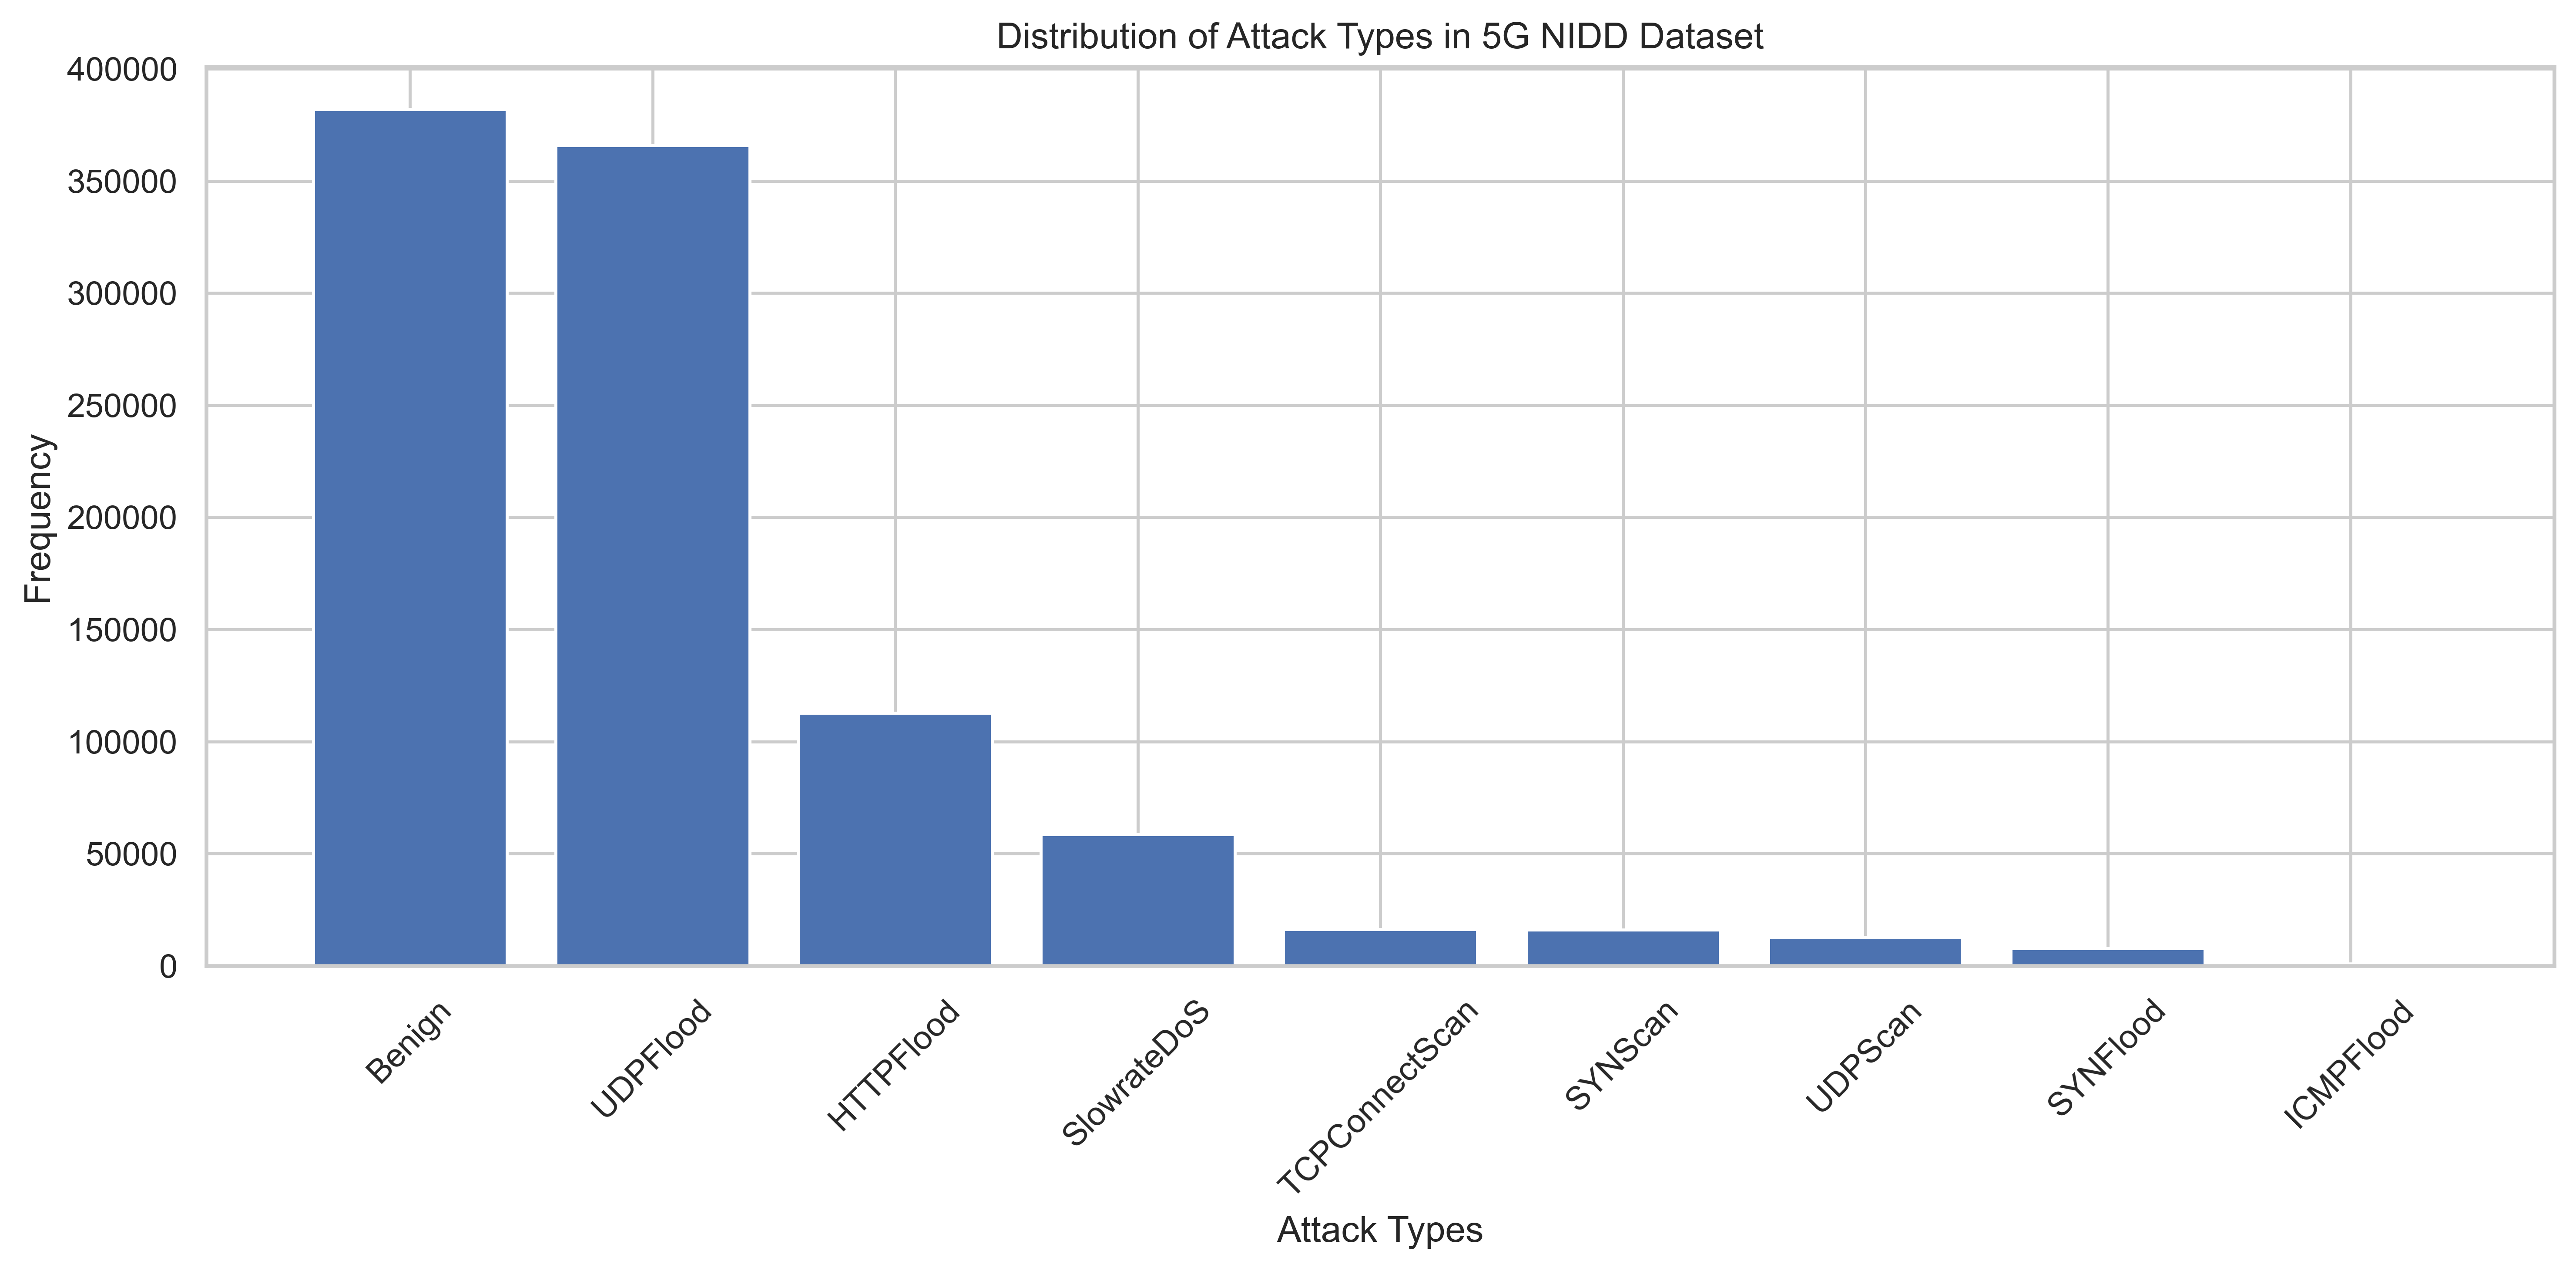

[Memory] Before Sampling (smote): 3302.39 MB
[Memory] After Sampling (smote): 3058.97 MB


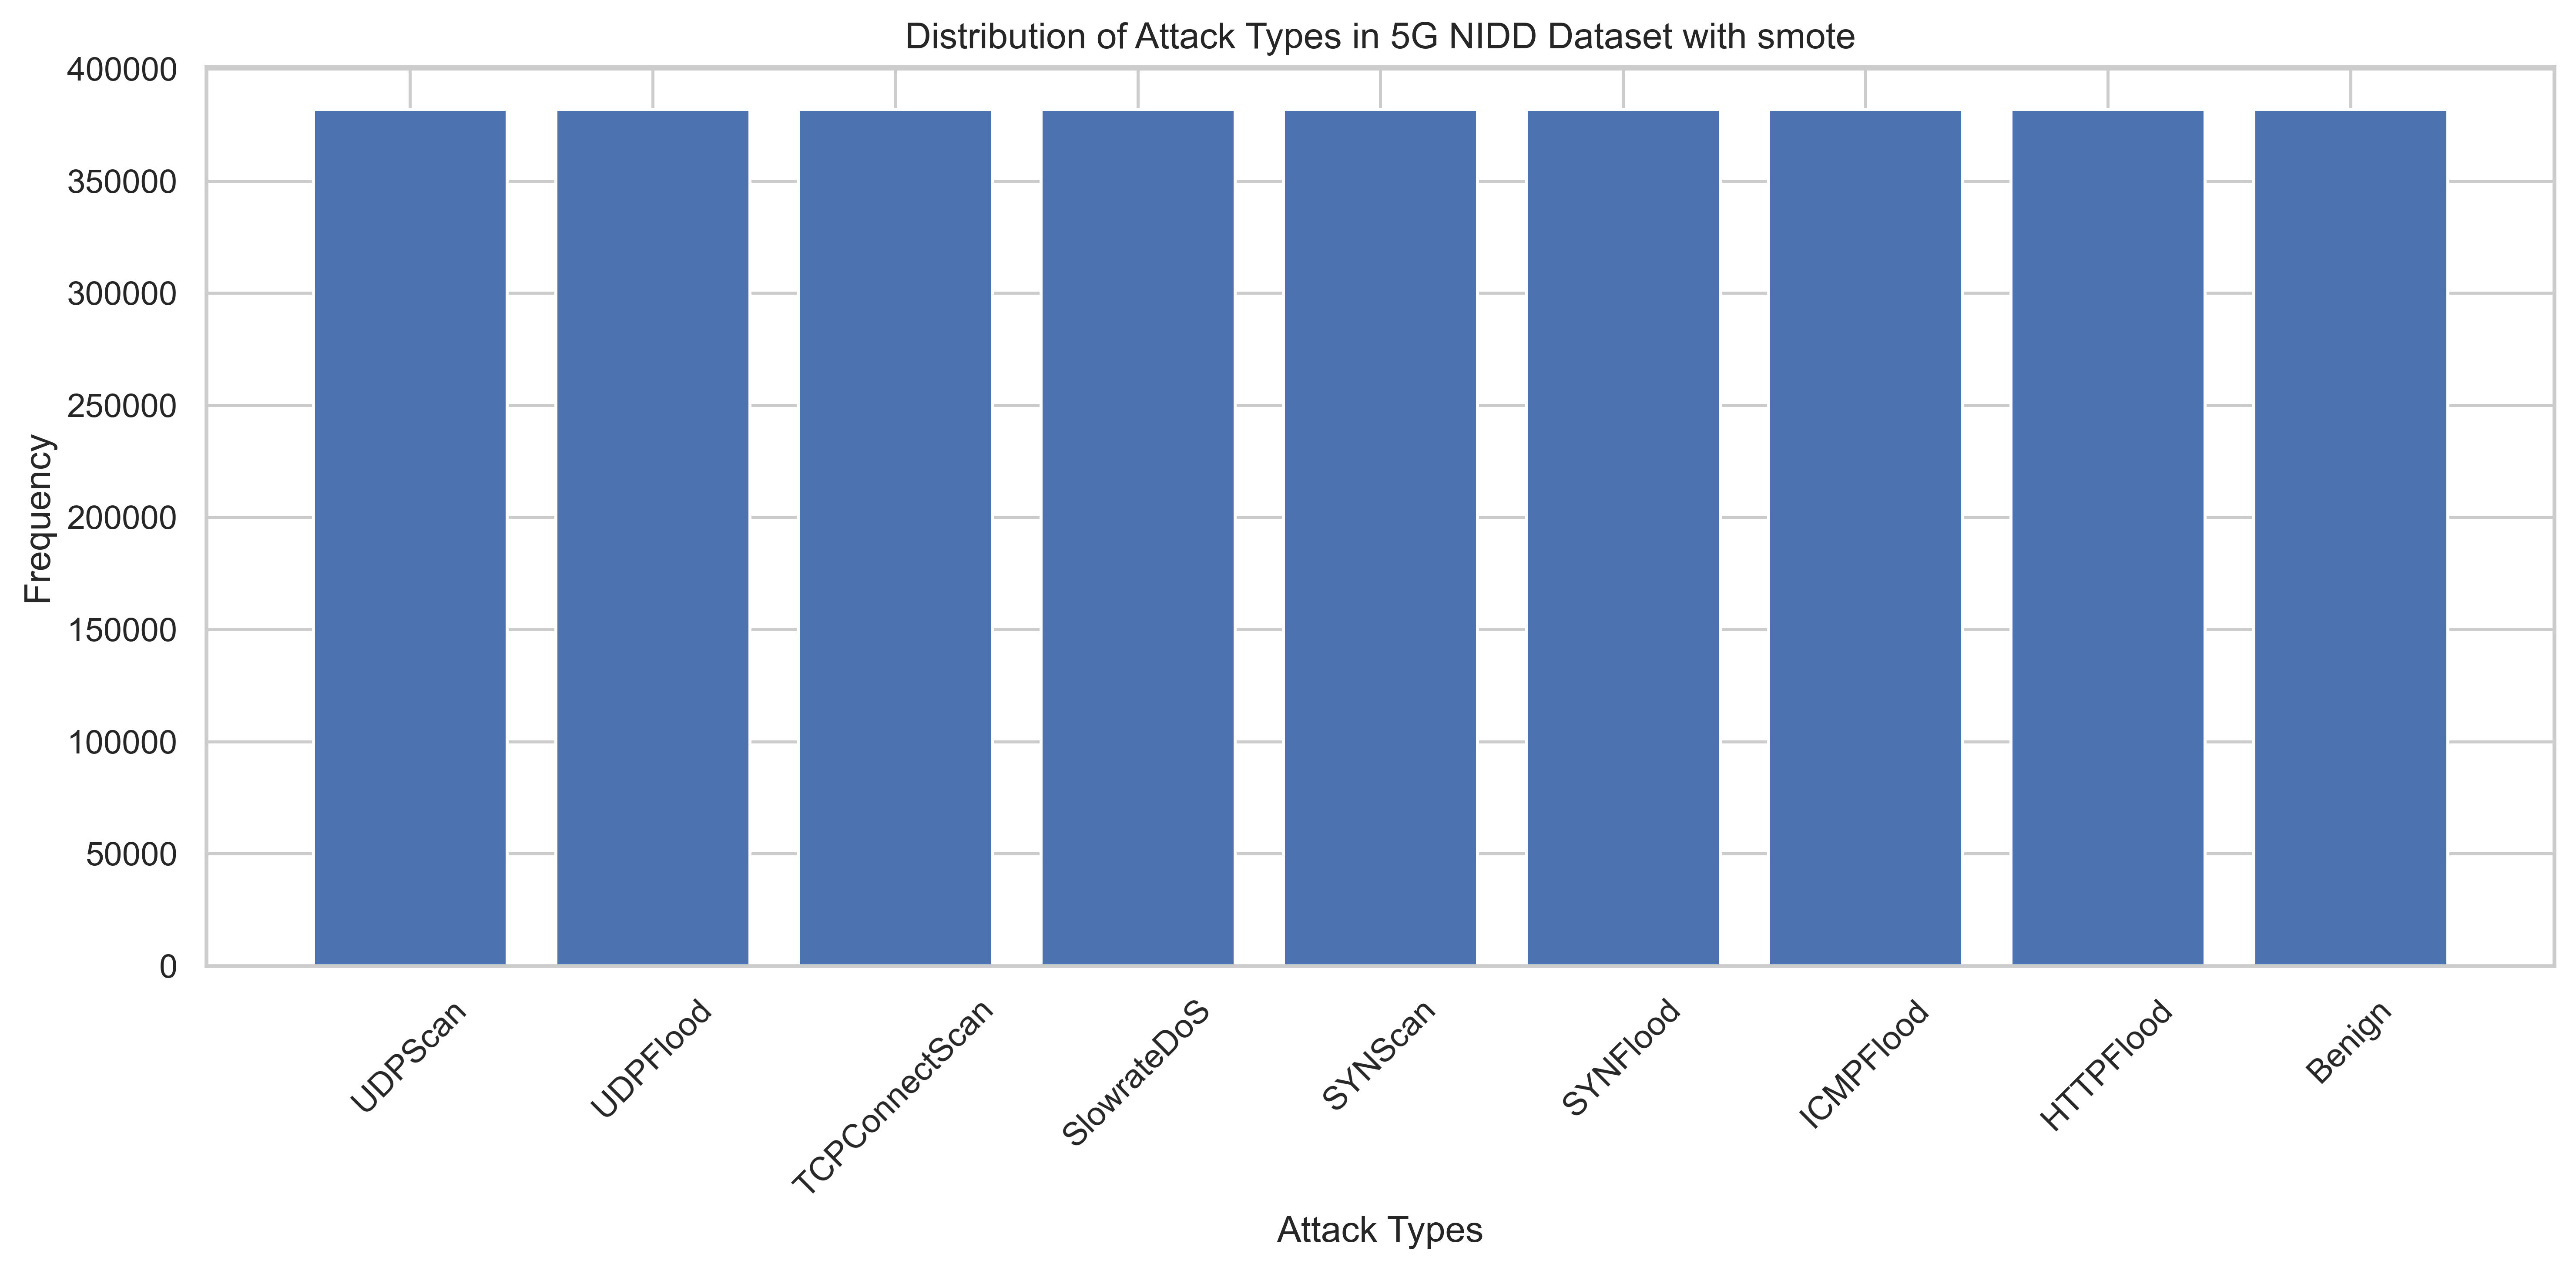

[Memory] Notebook - Ready for Training: 2329.95 MB


In [ ]:
X_train_processed, X_val_scaled, X_test_scaled, y_resampled, y_val, y_test = preprocessing(*preprocessing_args_list)
print_memory_usage("Notebook - Ready for Training")


# Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


## Logistic Regression

In [ ]:
linear_model = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, random_state=42)

start_time = time.time()
linear_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_lr = linear_model.predict(X_val_scaled)
prediction_time = time.time() - start_time


Logistic Regression Evaluation:
Accuracy: 0.94572611
Precision: 0.94878298
Recall: 0.94572611
F1 Score: 0.94655381
Training Time: 41.2440 seconds
Prediction Time: 0.0064 seconds
latency per sample: 0.00000005 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.95331486 0.93515401 0.94414711     47821
     HTTPFlood  0.97418580 0.92635935 0.94967081     14014
     ICMPFlood  0.31770833 1.00000000 0.48221344       122
      SYNFlood  0.98717949 0.98137255 0.98426745      1020
       SYNScan  0.99500250 0.99153386 0.99326515      2008
   SlowrateDoS  0.82199199 0.96784031 0.88897377      7214
TCPConnectScan  0.87293803 0.99441341 0.92972460      1969
      UDPFlood  0.95717641 0.95236847 0.95476639     45789
       UDPScan  0.98067633 0.99631902 0.98843579      1630

      accuracy                      0.94572611    121587
     macro avg  0.87335264 0.97170678 0.90171828    121587
  weighted avg  0.94878298 0.94572611 0.94655381    1

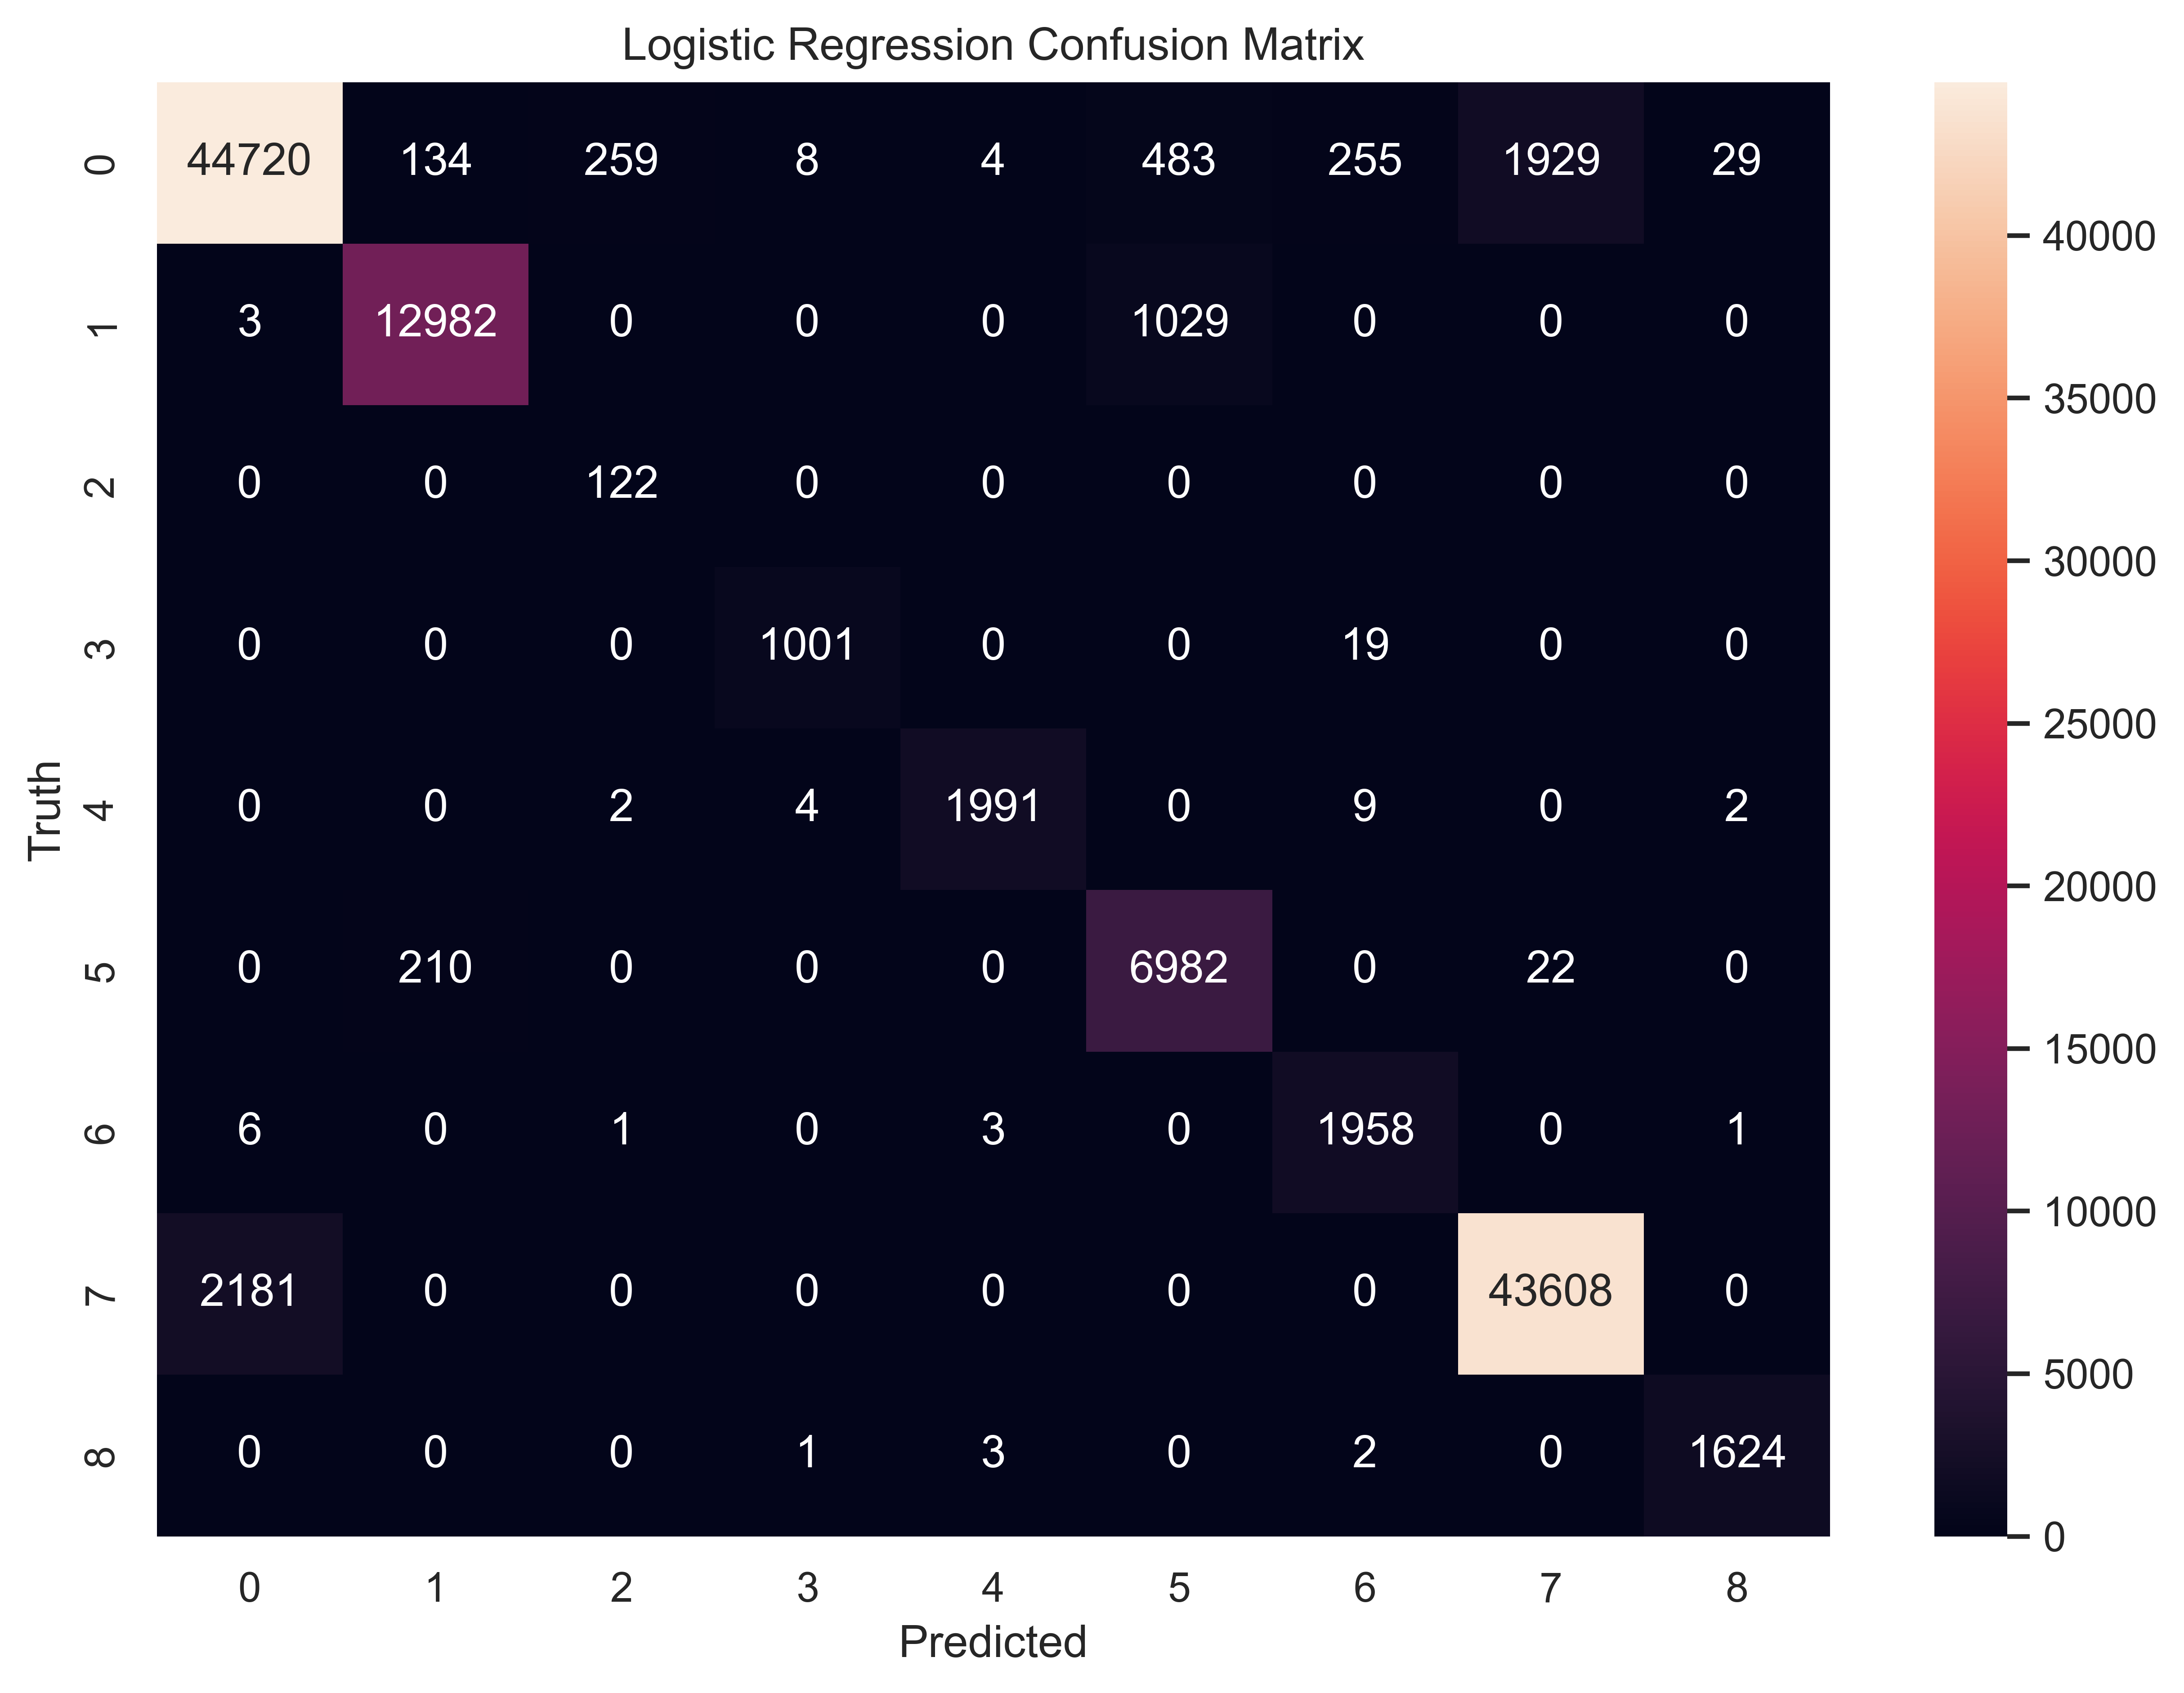

In [ ]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'logistic_regression')
results_file_name = 'logistic_regression_results.txt'
cm_title = 'Logistic Regression Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title, notes=lr_notes)
log_metrics(model_results, 'logistic_regression', accuracy, precision, recall, f1, training_time, prediction_time)

## Random Forest

In [ ]:
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1)
start_time = time.time()
rnd_forest.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rnd_forest.predict(X_val_scaled)
prediction_time = time.time() - start_time

# arguments for evaluation function
model_type = 'random_forest'
y_pred = y_pred_rf
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'

Evaluation:
Accuracy: 0.97909316
Precision: 0.97909322
Recall: 0.97909316
F1 Score: 0.97909311
Training Time: 27.6834 seconds
Prediction Time: 0.0880 seconds
latency per sample: 0.00000072 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97443515 0.97400724 0.97422114     47821
     HTTPFlood  0.99743242 0.99793064 0.99768147     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99800598 0.99701195 0.99750872      2008
   SlowrateDoS  0.99583796 0.99500970 0.99542366      7214
TCPConnectScan  0.99898322 0.99796851 0.99847561      1969
      UDPFlood  0.97288742 0.97331237 0.97309985     45789
       UDPScan  0.99632803 0.99877301 0.99754902      1630

      accuracy                      0.97909316    121587
     macro avg  0.99265669 0.99266816 0.99266216    121587
  weighted avg  0.97909322 0.97909316 0.97909311    121587



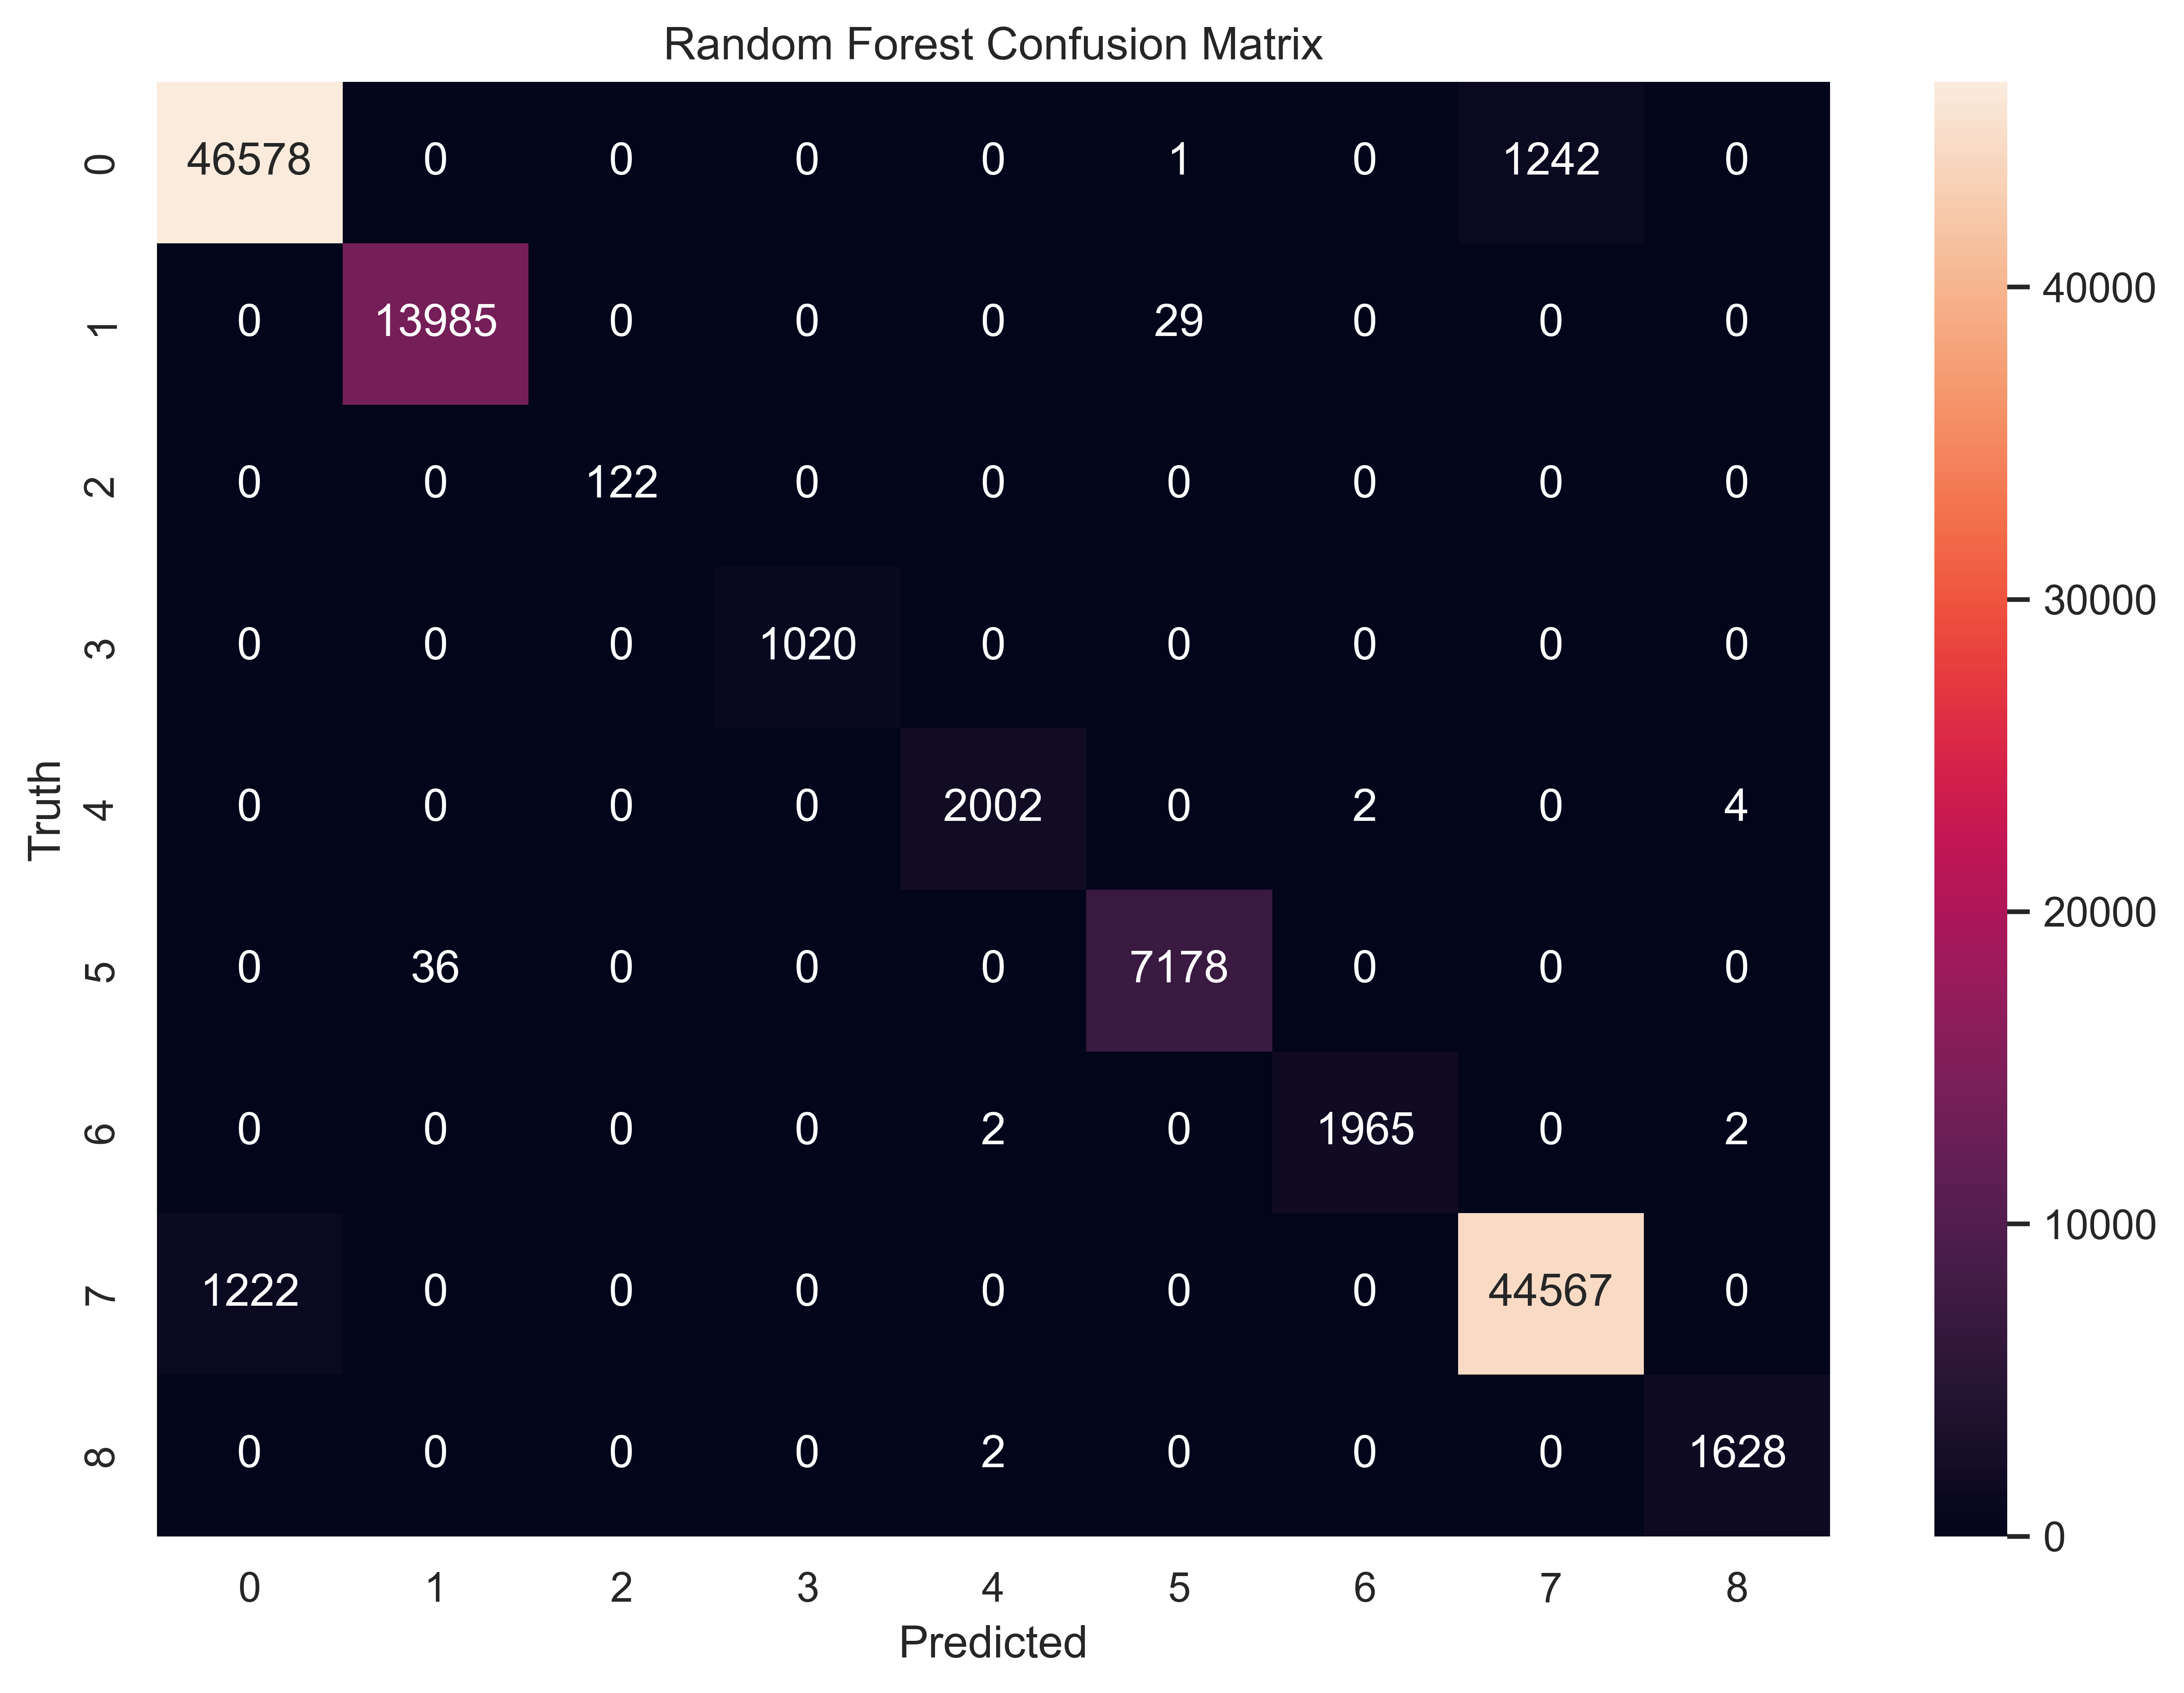

In [ ]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'random_forest')
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'
print("Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_rf, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title, notes=lr_notes)
log_metrics(model_results, 'random_forest', accuracy, precision, recall, f1, training_time, prediction_time)

## XGBoost

In [ ]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(output_encoder.classes_), eval_metric='mlogloss')

# Train the model
start_time = time.time()
xgb_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_xgb = xgb_model.predict(X_val_scaled)
prediction_time = time.time() - start_time

XGBoost Evaluation:
Accuracy: 0.94572611
Precision: 0.94878298
Recall: 0.94572611
F1 Score: 0.94655381
Training Time: 18.0474 seconds
Prediction Time: 0.1082 seconds
latency per sample: 0.00000089 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.95331486 0.93515401 0.94414711     47821
     HTTPFlood  0.97418580 0.92635935 0.94967081     14014
     ICMPFlood  0.31770833 1.00000000 0.48221344       122
      SYNFlood  0.98717949 0.98137255 0.98426745      1020
       SYNScan  0.99500250 0.99153386 0.99326515      2008
   SlowrateDoS  0.82199199 0.96784031 0.88897377      7214
TCPConnectScan  0.87293803 0.99441341 0.92972460      1969
      UDPFlood  0.95717641 0.95236847 0.95476639     45789
       UDPScan  0.98067633 0.99631902 0.98843579      1630

      accuracy                      0.94572611    121587
     macro avg  0.87335264 0.97170678 0.90171828    121587
  weighted avg  0.94878298 0.94572611 0.94655381    121587



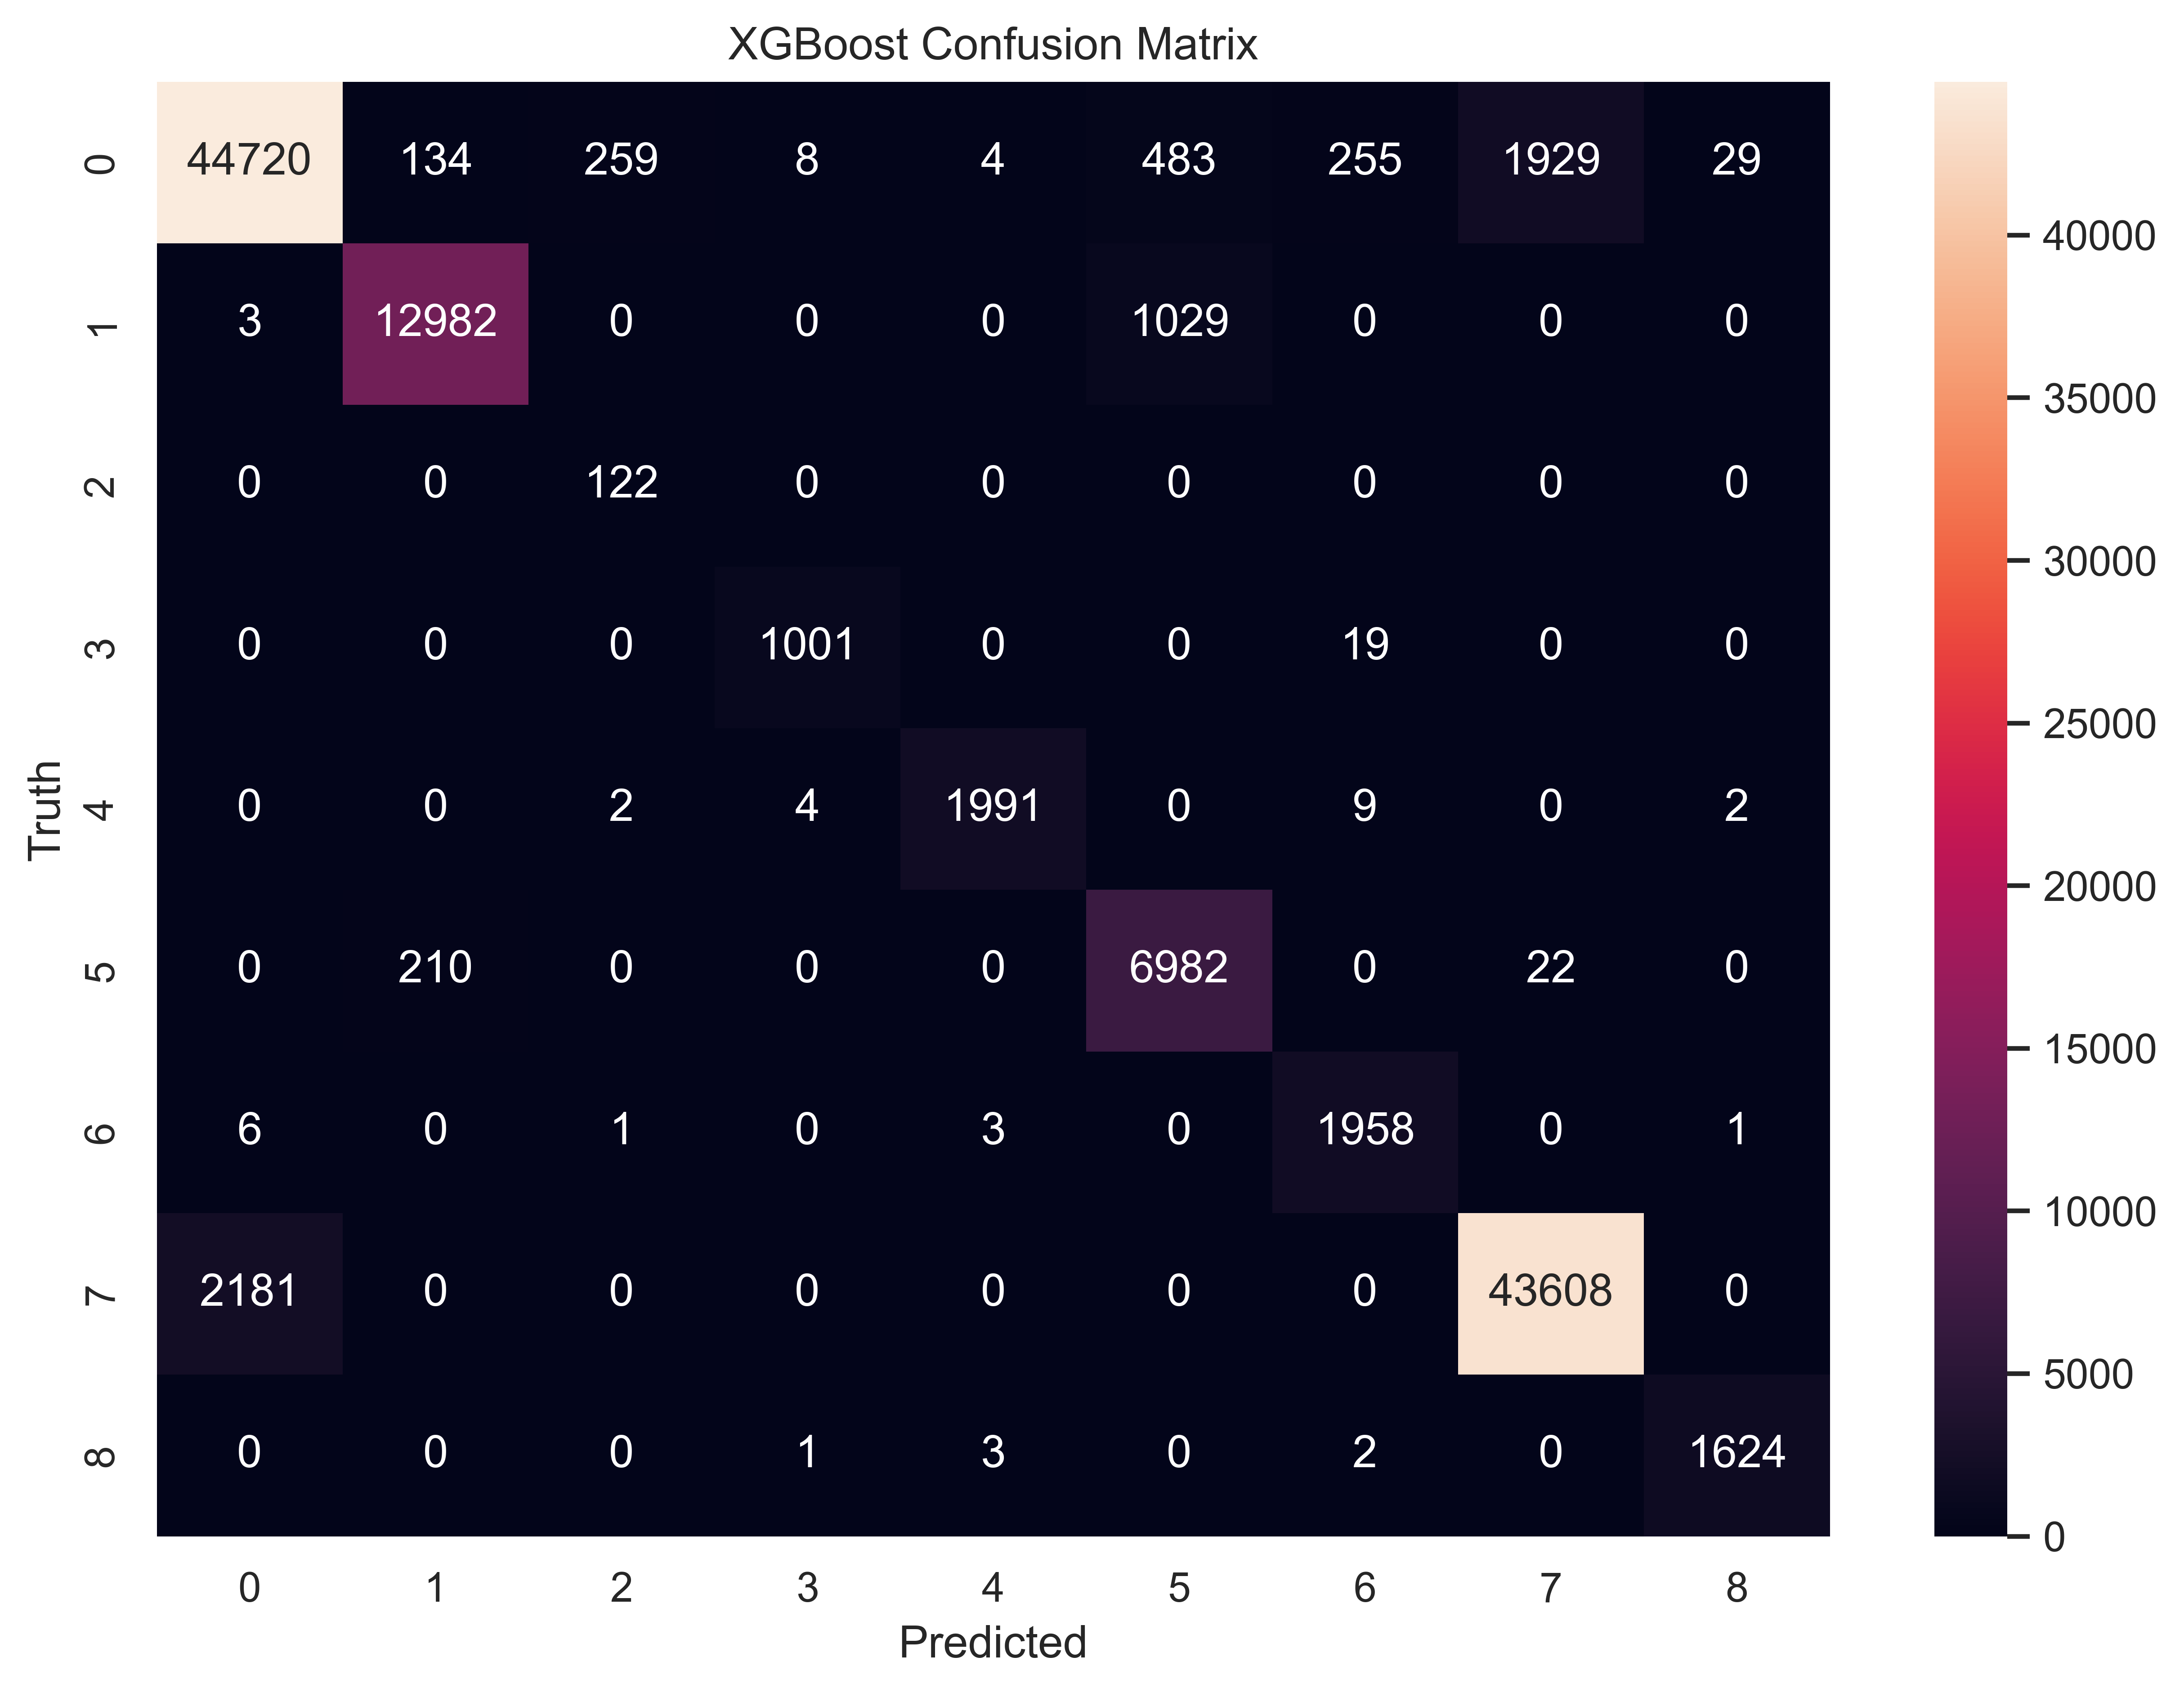

In [ ]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'xgboost')
results_file_name = 'xgboost_results.txt'
cm_title = 'XGBoost Confusion Matrix'
print("XGBoost Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title, notes=lr_notes)
log_metrics(model_results, 'xgboost', accuracy, precision, recall, f1, training_time, prediction_time)

## Naive Bayes

In [ ]:
# Create a Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
start_time = time.time()
nb_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_nb = nb_model.predict(X_val_scaled)
prediction_time = time.time() - start_time

Naive Bayes Evaluation:
Accuracy: 0.94572611
Precision: 0.94878298
Recall: 0.94572611
F1 Score: 0.94655381
Training Time: 0.3123 seconds
Prediction Time: 0.0495 seconds
latency per sample: 0.00000041 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.95331486 0.93515401 0.94414711     47821
     HTTPFlood  0.97418580 0.92635935 0.94967081     14014
     ICMPFlood  0.31770833 1.00000000 0.48221344       122
      SYNFlood  0.98717949 0.98137255 0.98426745      1020
       SYNScan  0.99500250 0.99153386 0.99326515      2008
   SlowrateDoS  0.82199199 0.96784031 0.88897377      7214
TCPConnectScan  0.87293803 0.99441341 0.92972460      1969
      UDPFlood  0.95717641 0.95236847 0.95476639     45789
       UDPScan  0.98067633 0.99631902 0.98843579      1630

      accuracy                      0.94572611    121587
     macro avg  0.87335264 0.97170678 0.90171828    121587
  weighted avg  0.94878298 0.94572611 0.94655381    121587



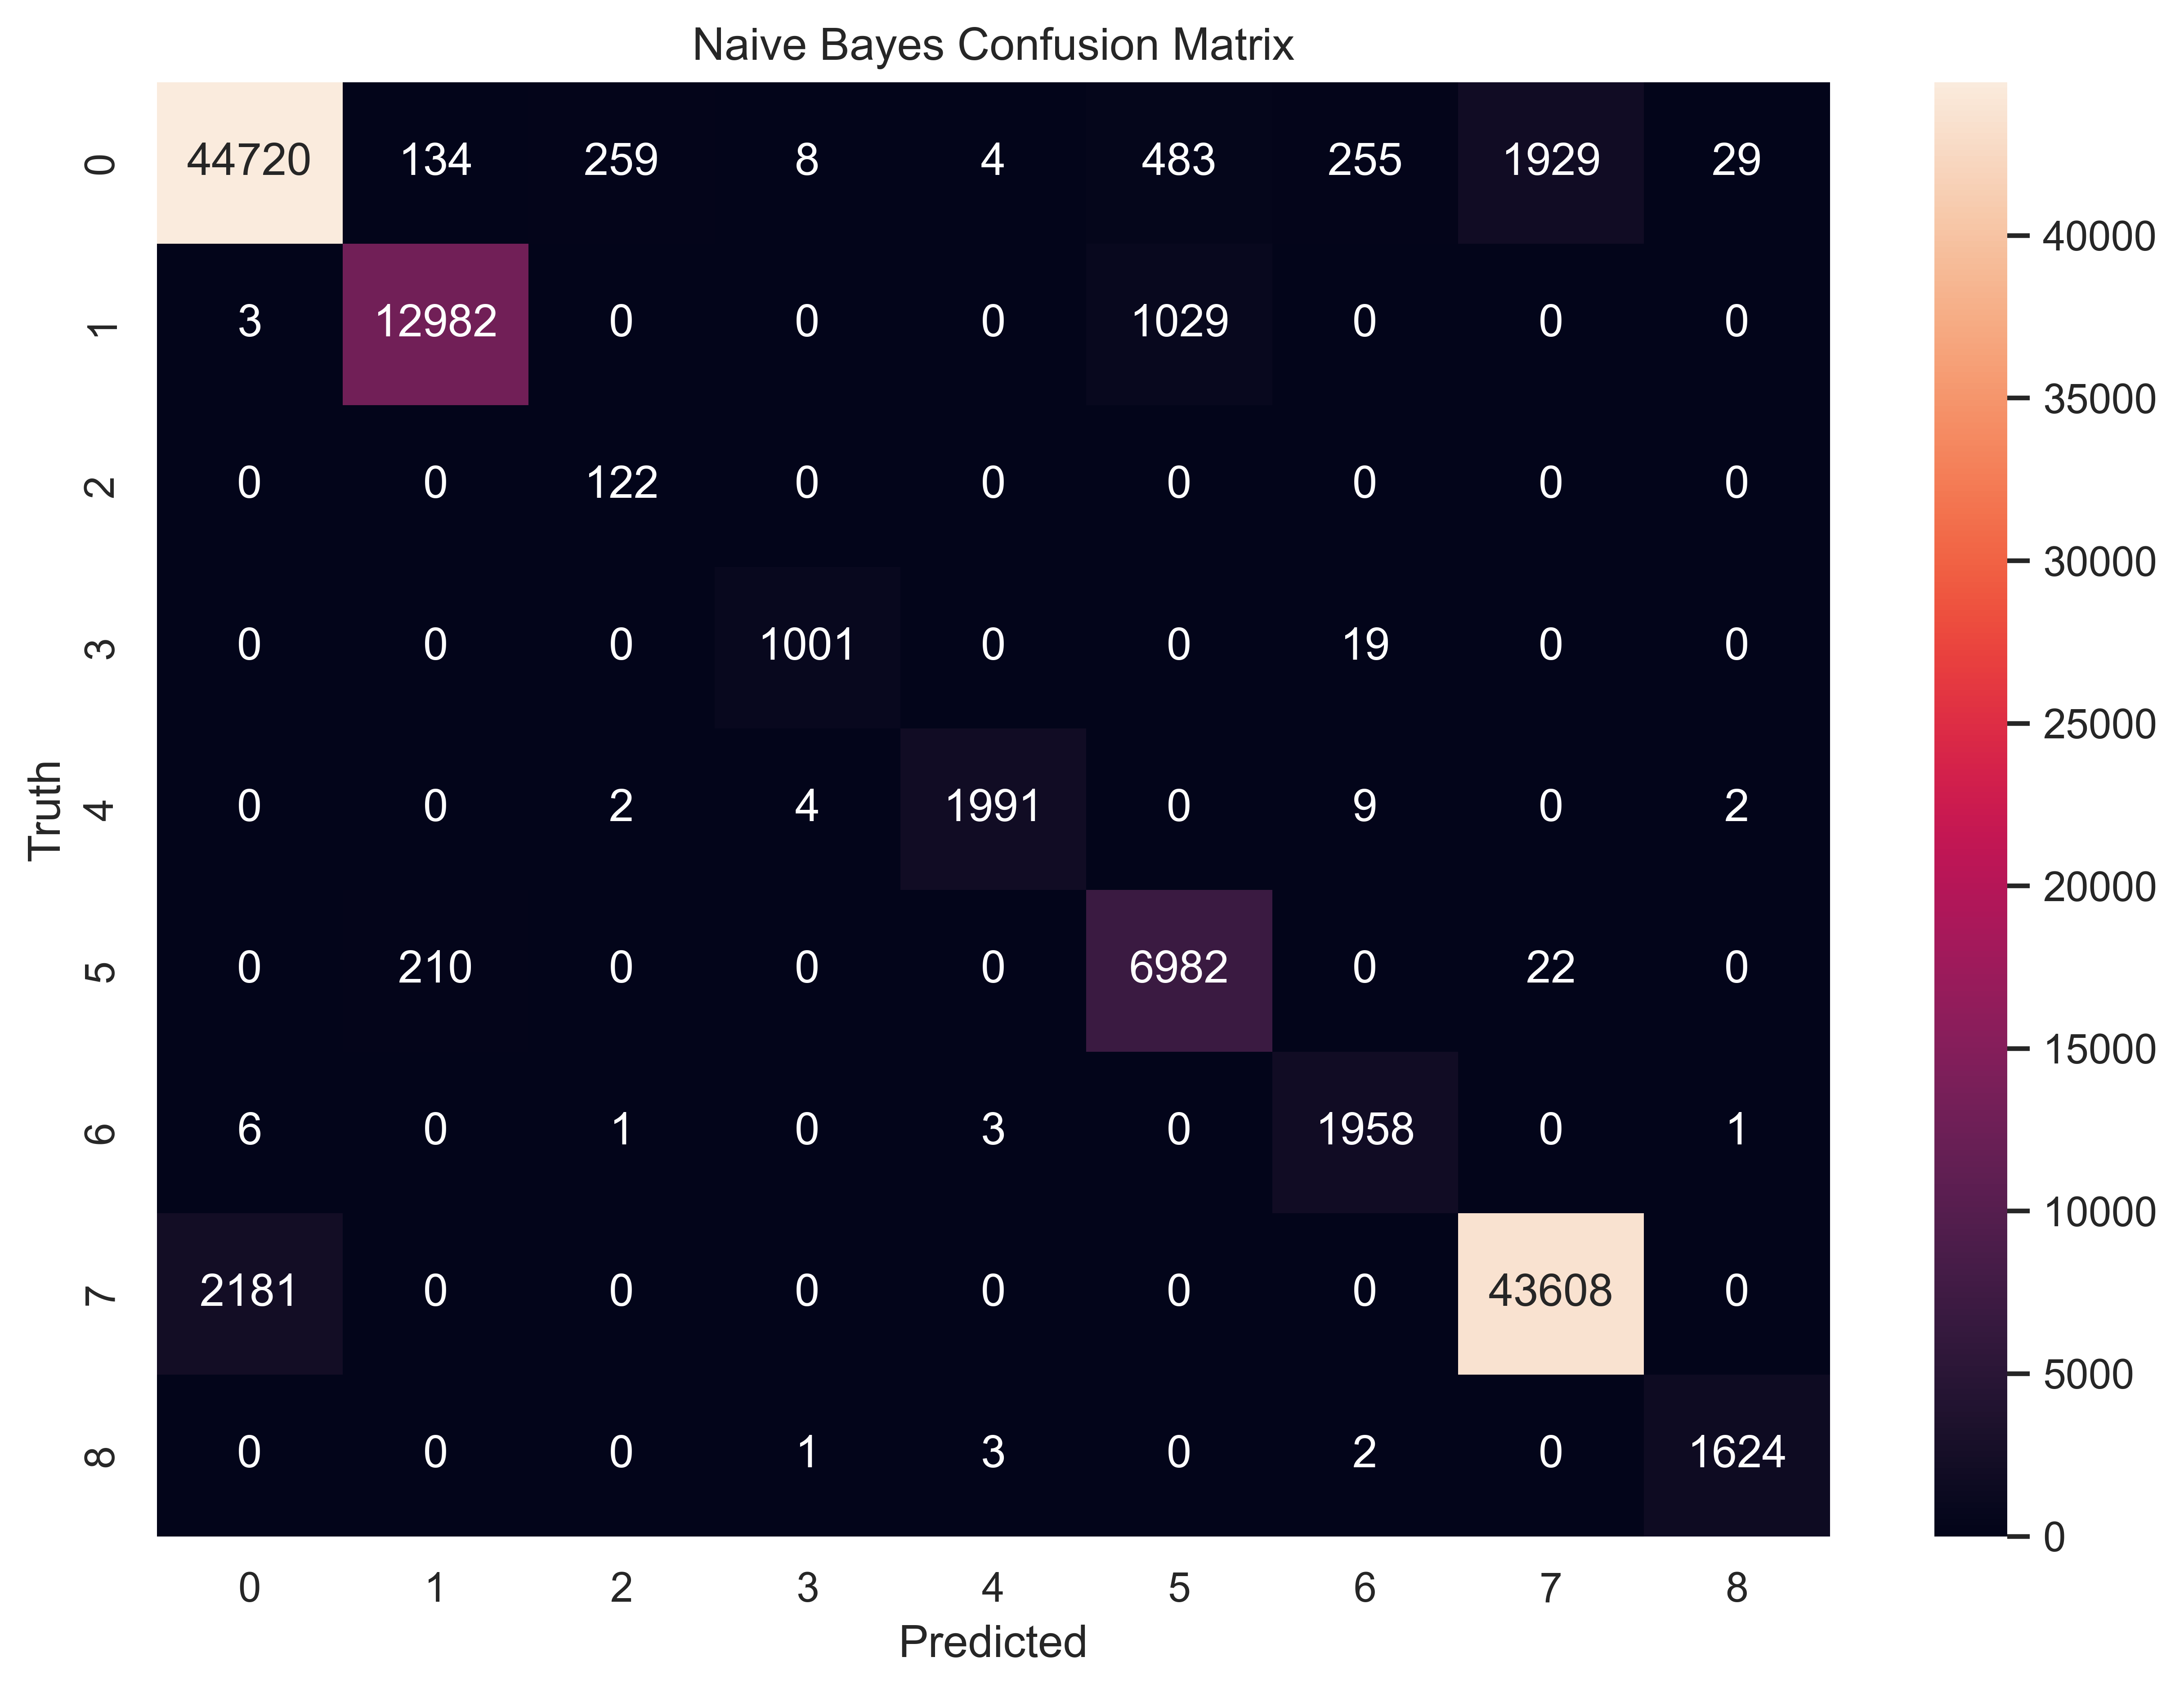

In [ ]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'naive_bayes')
results_file_name = 'naive_bayes_results.txt'
cm_title = 'Naive Bayes Confusion Matrix'
print("Naive Bayes Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title, notes=lr_notes)
log_metrics(model_results, 'naive_bayes', accuracy, precision, recall, f1, training_time, prediction_time)

## SVM

In [ ]:
LSVC = LinearSVC(dual=False, random_state=42)

### Use One-vs-Rest classifier

In [ ]:
ovr_classifier = OneVsRestClassifier(estimator=LSVC, n_jobs=-1)
start_time = time.time()
ovr_classifier.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_svm = ovr_classifier.predict(X_val_scaled)
prediction_time = time.time() - start_time

SVM Evaluation:
Accuracy: 0.94572611
Precision: 0.94878298
Recall: 0.94572611
F1 Score: 0.94655381
Training Time: 174.4660 seconds
Prediction Time: 0.0666 seconds
latency per sample: 0.00000055 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.95331486 0.93515401 0.94414711     47821
     HTTPFlood  0.97418580 0.92635935 0.94967081     14014
     ICMPFlood  0.31770833 1.00000000 0.48221344       122
      SYNFlood  0.98717949 0.98137255 0.98426745      1020
       SYNScan  0.99500250 0.99153386 0.99326515      2008
   SlowrateDoS  0.82199199 0.96784031 0.88897377      7214
TCPConnectScan  0.87293803 0.99441341 0.92972460      1969
      UDPFlood  0.95717641 0.95236847 0.95476639     45789
       UDPScan  0.98067633 0.99631902 0.98843579      1630

      accuracy                      0.94572611    121587
     macro avg  0.87335264 0.97170678 0.90171828    121587
  weighted avg  0.94878298 0.94572611 0.94655381    121587



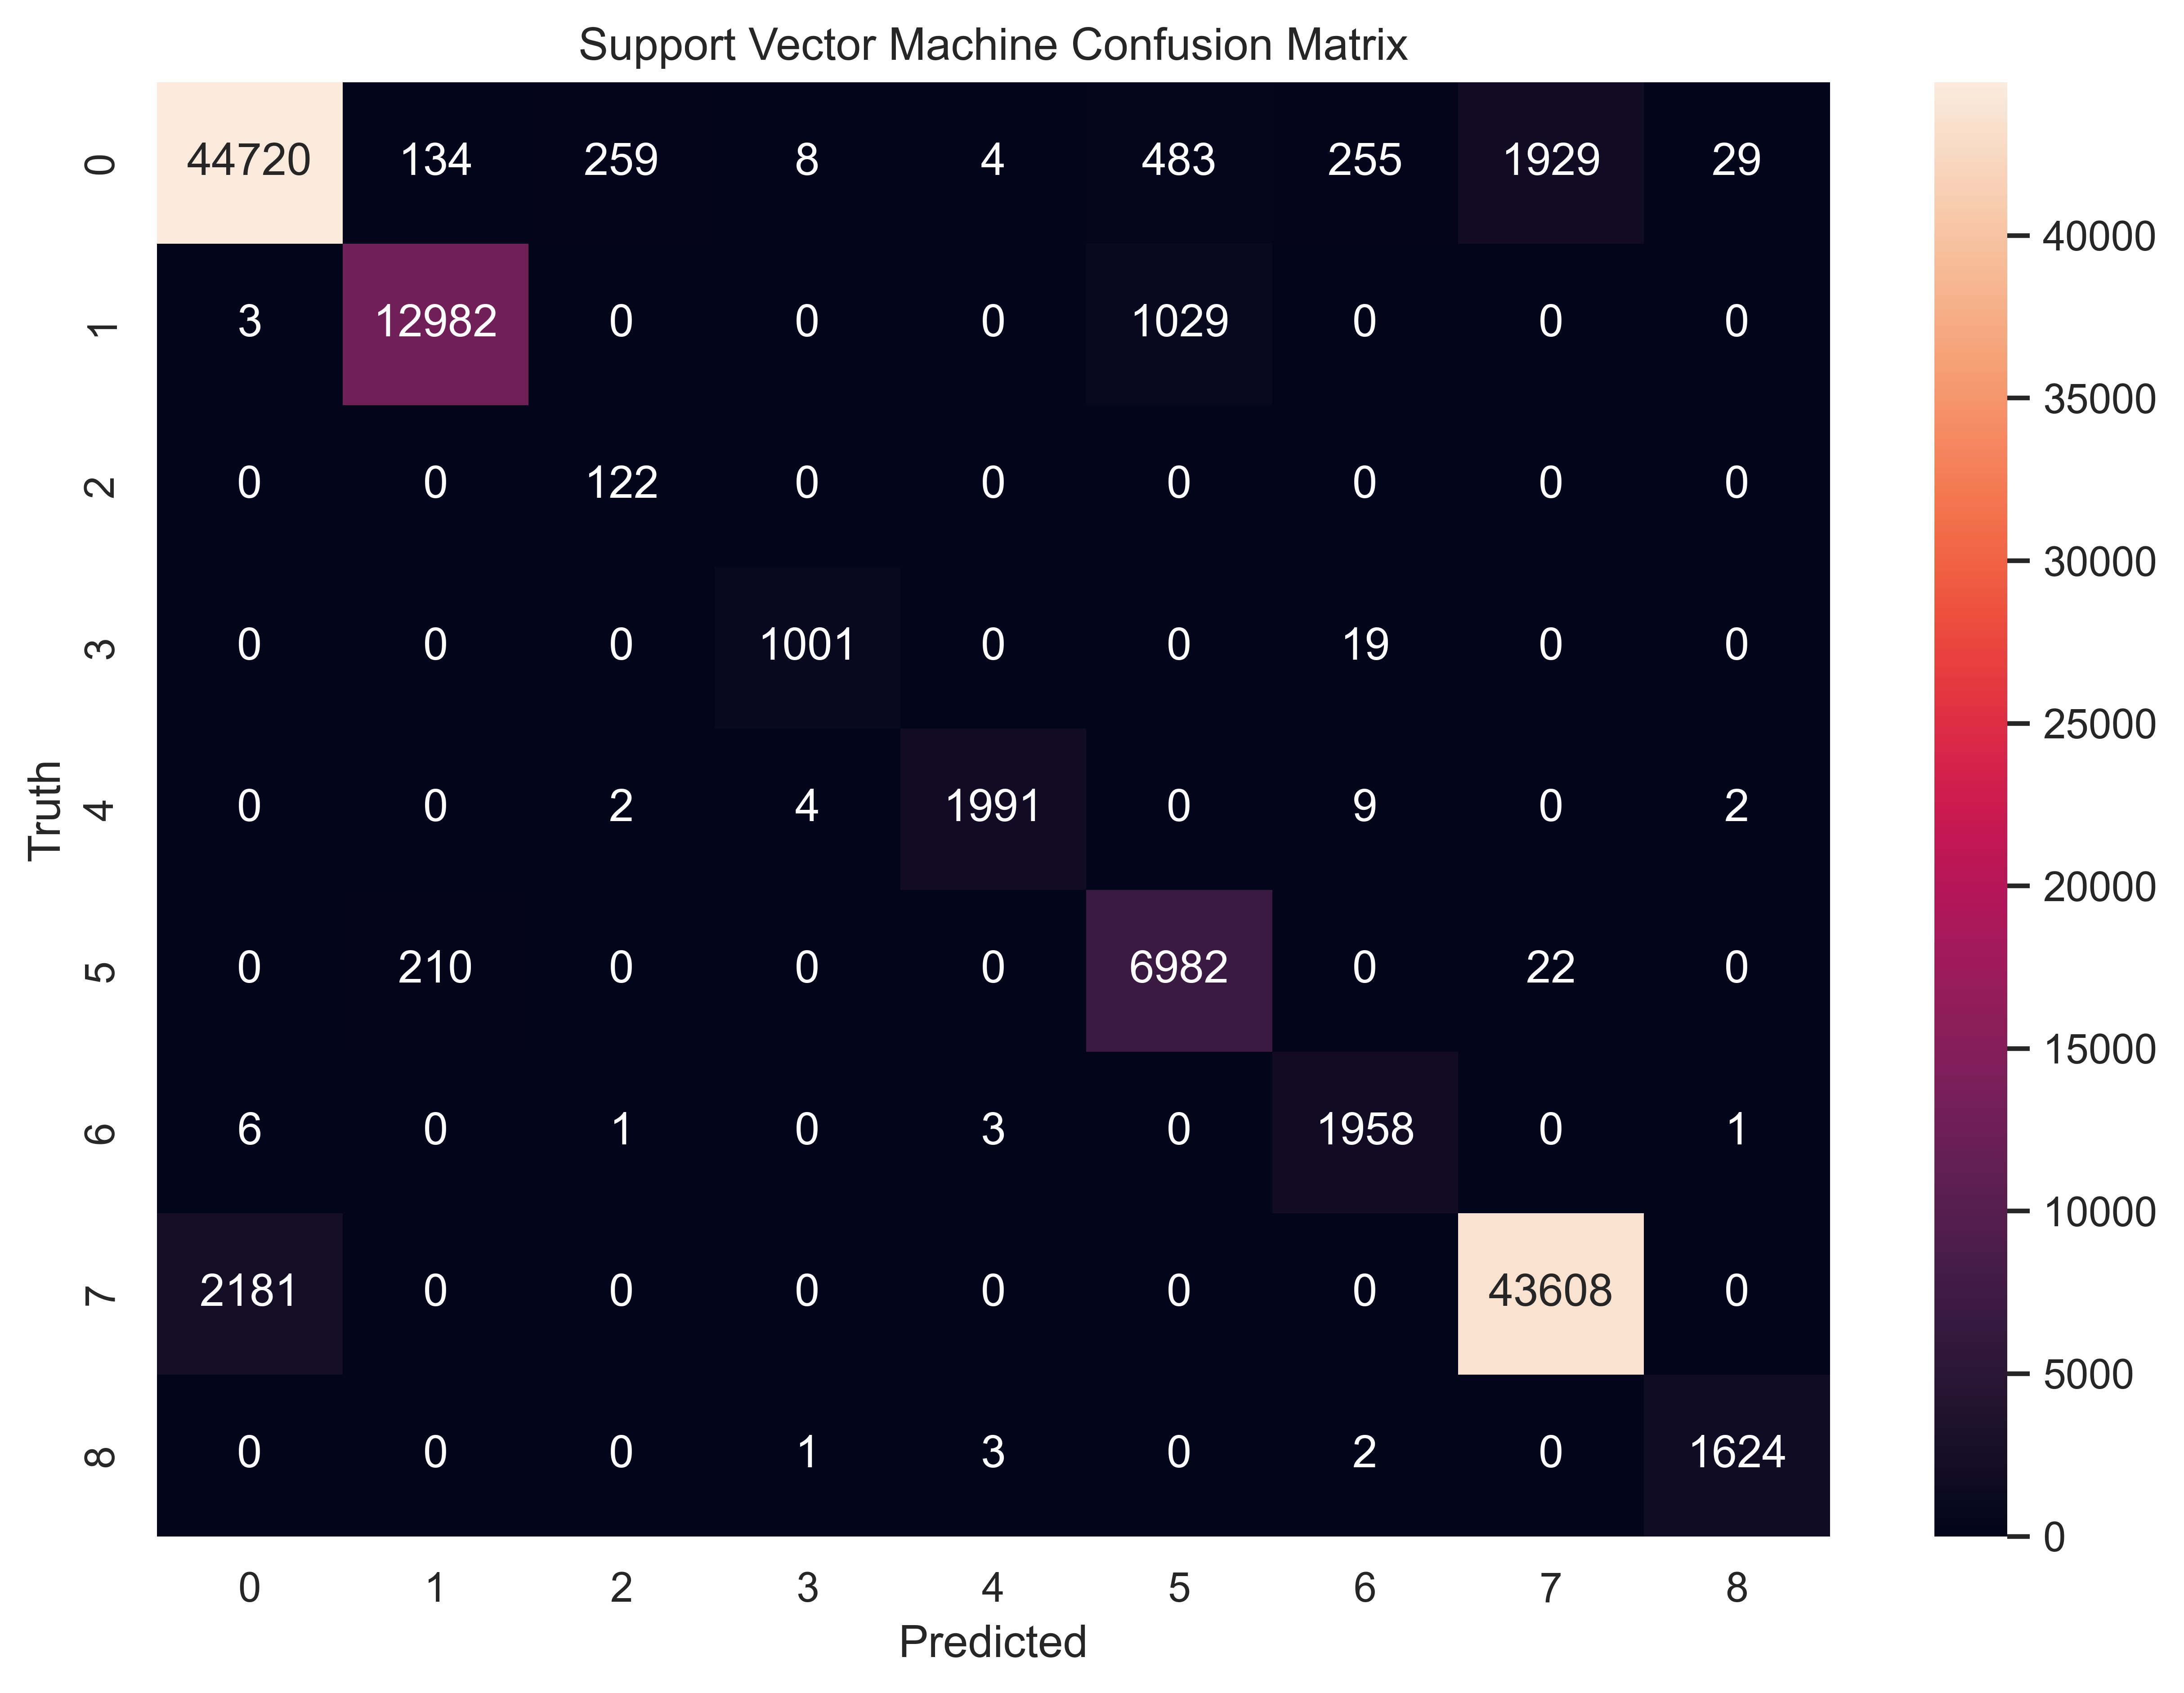

In [ ]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'svm')
results_file_name = 'svm_results.txt'
cm_title = 'Support Vector Machine Confusion Matrix'
print("SVM Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title, notes=lr_notes)
log_metrics(model_results, 'svm', accuracy, precision, recall, f1, training_time, prediction_time)

# Bar charts

Saved v1_comparison_accuracy.png


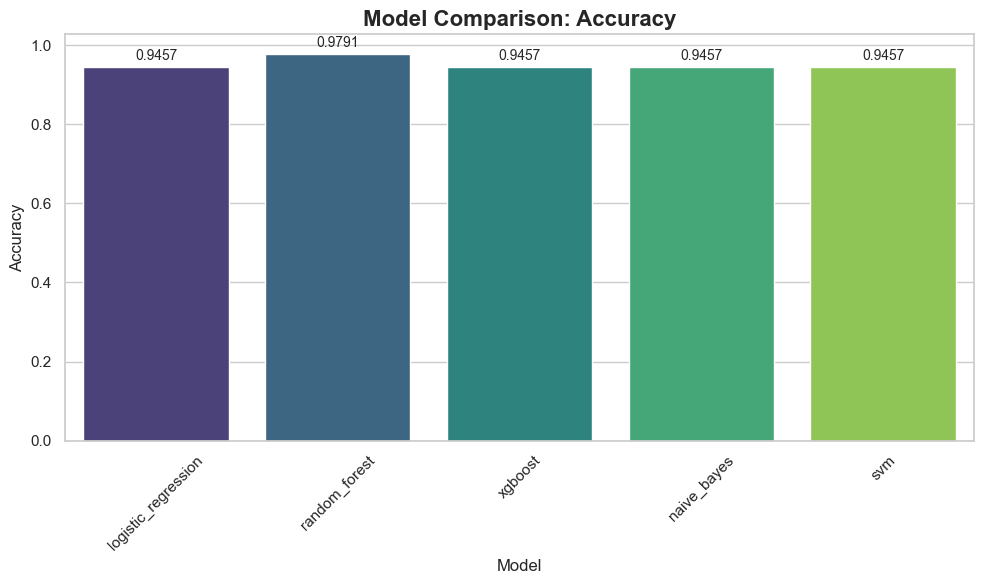

Saved v1_comparison_precision.png


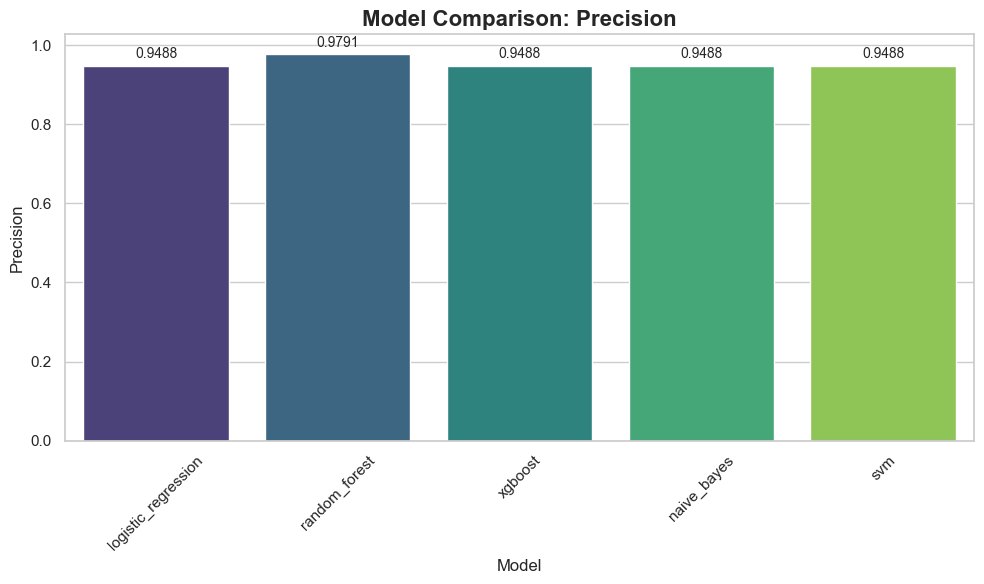

Saved v1_comparison_recall.png


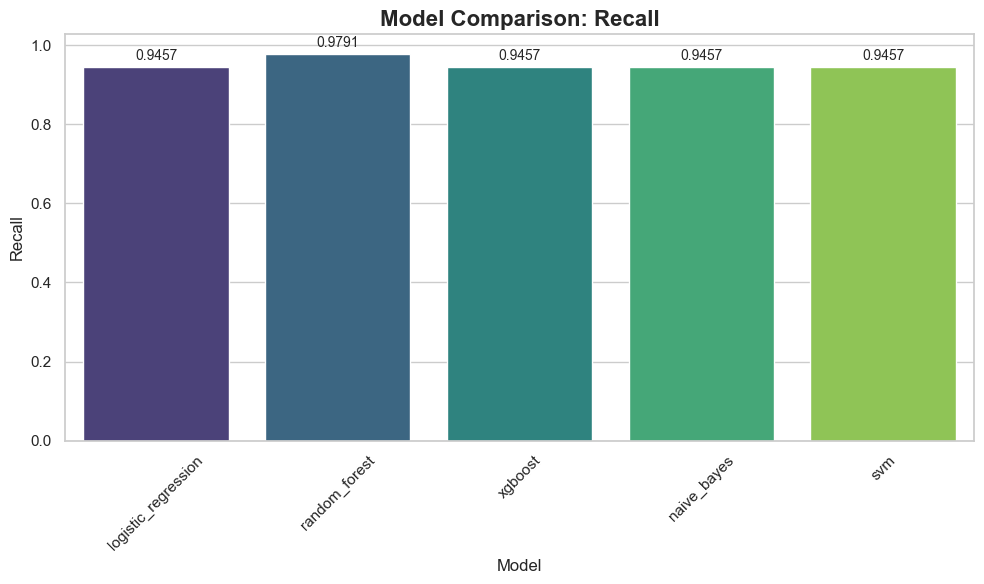

Saved v1_comparison_f1-score.png


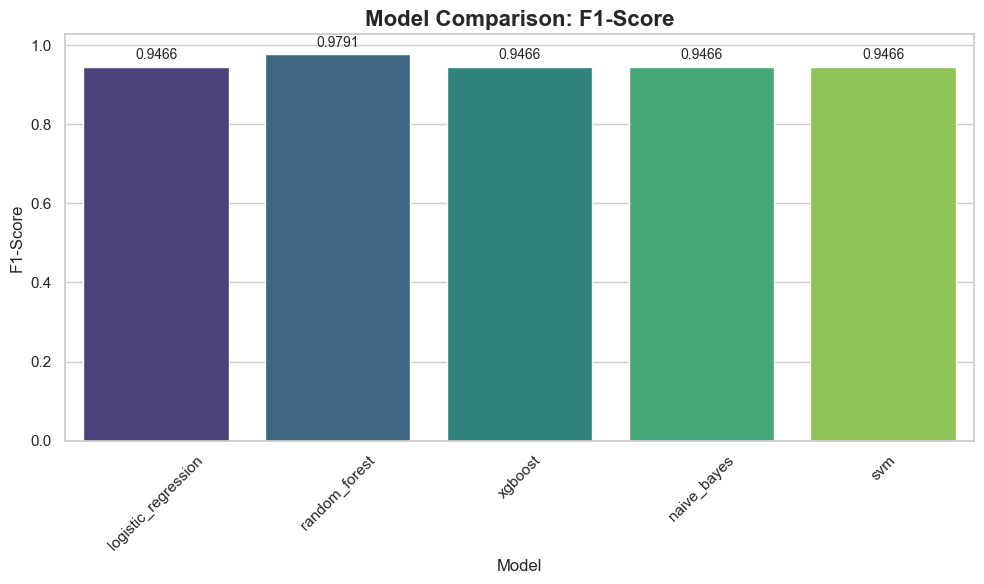

Saved v1_comparison_training_time_s.png


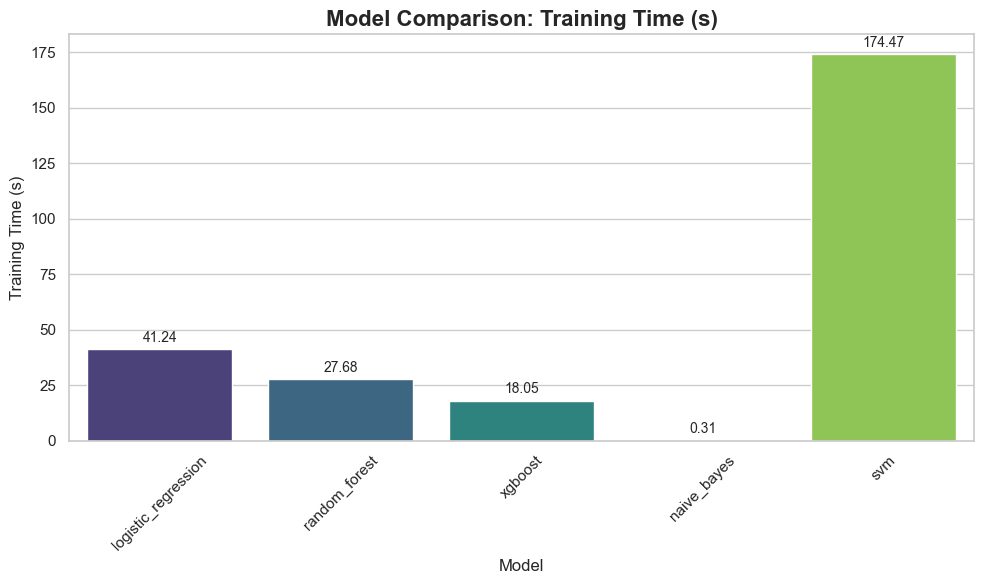

Saved v1_comparison_prediction_time_s.png


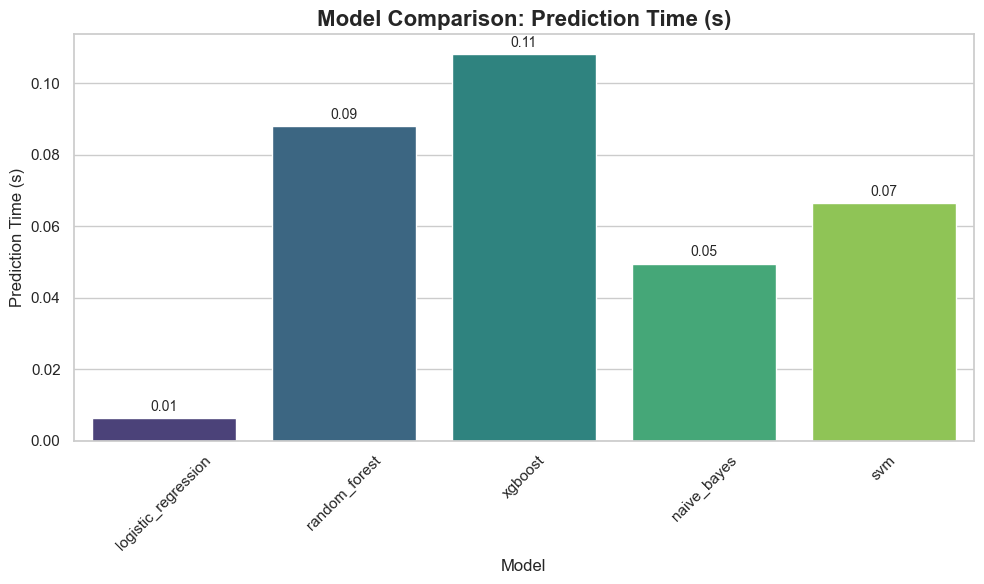

In [ ]:
machine_learning_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'bar charts')
plot_individual_metrics(model_results, machine_learning_output_dir, version)